In [1]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from PXPY import *
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
import GETFF
from joblib import Parallel, delayed
import importlib
#importlib.reload(ASYMMETRY)

Welcome to JupyROOT 6.26/06


In [2]:
###############################################################################
###############################################################################

#NEEDS INELASTIC ASYMMETRY, NITROGEN CONTAMINATION

###############################################################################
###############################################################################

In [3]:
Pass="2"
config="2"
generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3/final_2_{1}.npz")


In [4]:
W2min=CONFIG.Function_JSON("W2min",f"../config/Pass{Pass}/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/Pass{Pass}/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/Pass{Pass}/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/Pass{Pass}/cuts{config}.cfg")
hcalmin=CONFIG.Function_JSON("hcalmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/Pass{Pass}/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/Pass{Pass}/cuts{config}.cfg")

#  "dxmin"	: -0.481,
#  "dxmax"	: 0.498, old gen2


print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'hcalmin: {hcalmin}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Q2: {Q2}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

#W2min=-1.9
#dymin=-1
#W2max=2

W2min: 0
W2max: 1.5
dxmin: -0.8
dxmax: 0.8
dymin: -0.822
dymax: 0.8
hcalmin: 0.025
dybgmin: -1.4
dybgmax: 1.4
Q2: 3
Coin Min: 123 Coin Max: 134


In [5]:

new_coinmin=coinmin+6.5-6/2
new_coinmax=coinmax-5.5+6/2

In [6]:
new_coinmin

126.5

In [7]:
new_coinmax

131.5

In [8]:
#in GeV^2
m=.939565
Mp=.938
muN=-1.9103
mup=2.793

if config=="2":
    Q2=3
    tau=Q2/(4*m**2)
    theta=29.5*pi/180
if config=="3":
    Q2=6.83
    #Q2=6.62 #seans number
    tau=Q2/(4*m**2)
    theta=36.5*pi/180
if config=="4":
    Q2=9.82
    tau=Q2/(4*m**2)
    theta=35*pi/180

# Target Spin Direction

In [9]:
if config=="2":
    spintheta=59.34
    spinphi=1.84
if config=="3":
    spintheta=70.94
    spinphi=.51
if config=="4":
    spintheta=74.07
    spinphi=.55





In [10]:

fileNum=1
simconfig=config
if config=="4a" or config=="4b":
    simconfig="4"
genericSim=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN{simconfig}/simulation0.npz")
genericSimIN=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN2/insimulationNEW0.npz")

print(genericSim.files)
print(genericSimIN.files)



['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'ephi', 'trP', 'fnucl', 'weight', 'eHCAL']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP', 'fnucl', 'weight', 'mc_sig', 'mc_sigOld', 'mc_sigPol', 'mc_BETA', 'mc_THETA']


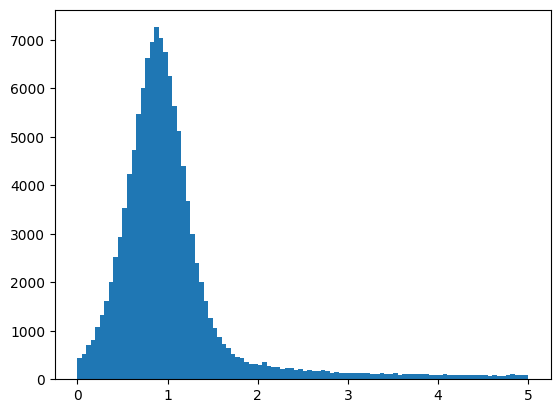

In [11]:
d=plt.hist(genericSim["W2"],bins=100,range=(0,5))

In [12]:
#%load_ext memory_profiler
#%memit doit()


In [13]:
dataTarget = pd.read_csv('../DB/ProcessedHe3Pol.csv')
dataBeam = pd.read_csv('../DB/ProcessedBeamPol.csv')
target_run_num = dataTarget['Run Number'].to_numpy()
target_pol = dataTarget['Polarization'].to_numpy()
target_polE=dataTarget['Error'].to_numpy()
beam_run_num = dataBeam['Run Number'].to_numpy()
beam_pol = dataBeam['Polarization'].to_numpy()
beam_polE=dataBeam['Error'].to_numpy()

In [14]:
target_pol/100

array([0.33784094, 0.34959488, 0.35102284, ..., 0.40446772, 0.34115021,
       0.22716826])

In [15]:
target_polE/100

array([0.01700711, 0.01762116, 0.01779658, ..., 0.01687292,        nan,
              nan])

In [16]:
print("hehe")

hehe


In [18]:
%%time
if(len(generic["dx"])<3000000):
    
    useGrinch=False

    
    genericMaster = {}
    base_dir = f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3"
    i = 0
    print(f"NumPy array directory = {base_dir}")
    while os.path.exists(f"{base_dir}/final_2_{i}.npz"):
        print(f"Loading in file {i}")
       # if i>5:            #GPS
         #   break            #GPS
        file_path = f"{base_dir}/final_2_{i}.npz"
        data = np.load(file_path)

        cut=(data["ePS"]>0.2)
        if Pass=="2":
            grinchcut=(data["grinch_clus_size"]>=2)&(data["grinch_clus_trackindex"]==0)
            antigrinchcut=(data["grinch_clus_size"]<2)|(data["grinch_clus_trackindex"]!=0)
            pscut=(data["ePS"]>0) #GPS
            bbcalE=data["eSH"]+data["ePS"]
            gemP=data["trP"]
            
            epcut=bbcalE/gemP>.7 #GPS
            pscut=(data["ePS"]>0.1)
            #pscut=(data["ePS"]>0)
            if useGrinch:
                print("using grinch cut")
                #cut=antigrinchcut  #ANTIG
                cut=grinchcut
            else:
                print("using ps cut")
                cut=pscut#&epcut
        for key in data.files:
            if key not in genericMaster:
                cut_data = data[key][cut]
                genericMaster[key] = cut_data

            else:
                cut_data = data[key][cut]
                genericMaster[key] = np.concatenate((genericMaster[key], cut_data))

        data.close()
        i += 1

    print(f"Loaded {i} files into genericMaster.")


NumPy array directory = /media/research/TOSHIBA EXT/GEn/NumpyData/Pass2/GEN2/He3
Loading in file 0
using ps cut
Loading in file 1
using ps cut
Loading in file 2
using ps cut
Loading in file 3
using ps cut
Loading in file 4
using ps cut
Loading in file 5
using ps cut
Loading in file 6
using ps cut
Loading in file 7
using ps cut
Loading in file 8
using ps cut
Loading in file 9
using ps cut
Loading in file 10
using ps cut
Loading in file 11
using ps cut
Loading in file 12
using ps cut
Loading in file 13
using ps cut
Loading in file 14
using ps cut
Loading in file 15
using ps cut
Loading in file 16
using ps cut
Loading in file 17
using ps cut
Loaded 18 files into genericMaster.
CPU times: user 19.5 s, sys: 15.9 s, total: 35.3 s
Wall time: 1min 30s


In [19]:
generic=genericMaster

In [20]:
new_W2min=.87-8/10
new_W2max=.88+8/20
new_dxmin=-.1-17/20
new_dxmax=.1+17/20
new_dymin=-.1-6/10
new_dymax=.1+6/10
psmin=.2
epmin=.7
new_coinmin=coinmin+6.5-7/2
new_coinmax=coinmax-6.5+7/2


Text(0.5, 1.0, 'GEN2')

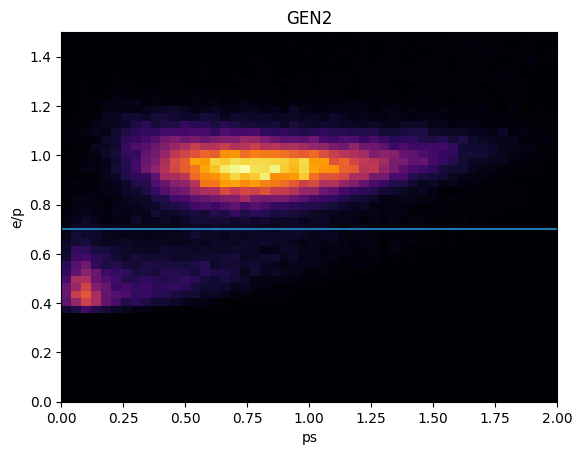

In [28]:
bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]

wcut=(generic["W2"] < new_W2max)&(generic["W2"]>new_W2min) 
dycut=(generic["dy"]<new_dymax)&(generic["dy"]>new_dymin) 
dxcut=(generic["dx"] < new_dxmax)&(generic["dx"]>new_dxmin) 
coincut=(new_coinmin < generic["coin_time"])&(generic["coin_time"] < new_coinmax)
fullcut=wcut  &dycut & dxcut #& coincut
d=plt.hist2d(generic["ePS"][fullcut],bbcalE[fullcut]/gemP[fullcut],
             bins=(50,50),range=((0,2),(0,1.5)),cmap='inferno')
plt.axhline(.7)
#plt.axvline(.2)
#plt.axhline(1.05)
plt.ylabel("e/p")
plt.xlabel("ps")
plt.title("GEN2")

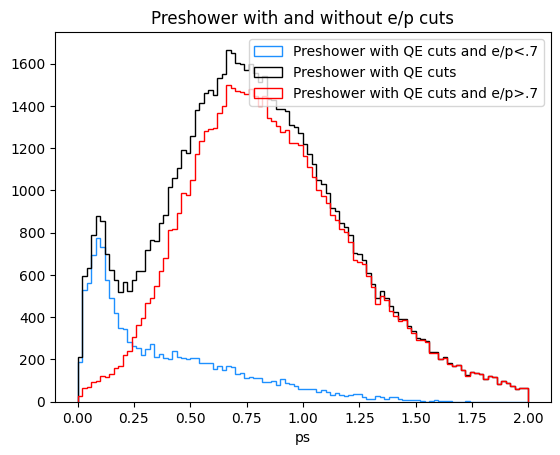

In [29]:
epcut=bbcalE/gemP>.7

d=plt.hist(generic["ePS"][fullcut&~epcut],color='dodgerblue',
           label='Preshower with QE cuts and e/p<.7',histtype='step',bins=100,range=(0,2))
d=plt.hist(generic["ePS"][fullcut],histtype='step',color='black',
           label='Preshower with QE cuts',bins=100,range=(0,2))
d=plt.hist(generic["ePS"][fullcut&epcut],histtype='step',color='red',
           label='Preshower with QE cuts and e/p>.7',bins=100,range=(0,2))
plt.title("Preshower with and without e/p cuts")
plt.xlabel("ps")
plt.legend(loc='upper right')

# Cuts

### Making the correct helicity

In [21]:


IHWP_IN=np.where(generic["IHWP"]==1)
helicity=generic["helicity"]
helicity[IHWP_IN]*=-1


### Cuts for data, bgsim, np sim 

In [110]:
bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]

wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
coincut=(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)
epcut=abs(bbcalE/gemP-.95)<.25
runnumcut=generic["runnum"]>2165

fullcut=wcut & dycut & dxcut & coincut&epcut&runnumcut
fullcutfordx=wcut&dycut&coincut&epcut&runnumcut

accidentalcut=wcut&dycut&dxcut&epcut&runnumcut


anticoincut=(coinmin-8 > generic["coin_time"])|(generic["coin_time"] > coinmax+5)

hpluscut=helicity==-1 # opposite for kin2
hminuscut=helicity==1

bgcut=(genericSimIN["W2"] < W2max)&(genericSimIN["W2"]>W2min)
antibgcut=(abs(generic["dy"])>1.2)&wcut&coincut
antibgAcut=(abs(generic["dy"])>2)&wcut&coincut

Simwcut=(genericSim["W2"] < W2max)&(genericSim["W2"]>W2min) 
Simdycut=(abs(genericSim["dy"]) < 0.5) 
Simdxcut=(genericSim["dx"] < dxmax)&(genericSim["dx"]>dxmin) 
Simfullcut=Simwcut & Simdycut & Simdxcut

InSimdxcut=(genericSimIN["dx"] < dxmax)&(genericSimIN["dx"]>dxmin)
InSimdycut=(genericSimIN["dy"] < dymax)&(genericSimIN["dy"]>dymin)

protoncut=genericSim["fnucl"]==1
neutroncut=genericSim["fnucl"]==0
weight=genericSim["weight"]



sigma=genericSimIN["mc_sig"]
sigmaold=genericSimIN["mc_sigOld"]
sigmapol=genericSimIN["mc_sigPol"]
THETA=genericSimIN["mc_THETA"]
BETA=genericSimIN["mc_BETA"]
Q2_in=genericSimIN["Q2"]
nu_in=genericSimIN["nu"]
W2_in=genericSimIN["W2"]
x_in  = Q2_in/(2.0*Mp*nu_in)
dy_in=genericSimIN["dy"]
dx_in=genericSimIN["dx"]

dy_incut=(dy_in<dymax)&(dy_in>dymin)
bgcut=(W2_in<W2max)&(W2_in>W2min)#&(abs(dy_in) < 0.5)#&(sigma<1e-39)##&(Q2<6.1)#
sigmacut=(sigma>6e-39)
goodsigmacut=sigma<.4e-37

# Peak at Cut Variables

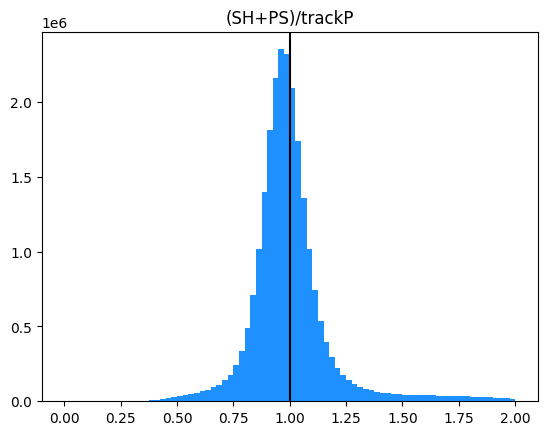

In [21]:
d=plt.hist(bbcalE/gemP,bins=80,range=(0,2),color='dodgerblue')
plt.axvline(1,color='black')
plt.title("(SH+PS)/trackP")
epcut=abs(bbcalE/gemP-.95)<.25

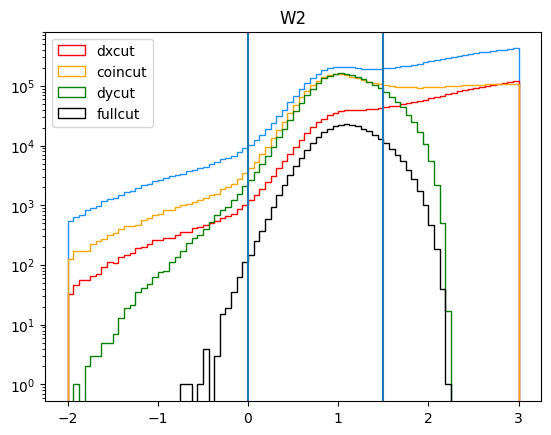

In [22]:
d=plt.hist(generic["W2"],bins=80,range=(-2,3),color='dodgerblue',histtype='step')
d=plt.hist(generic["W2"][dxcut],bins=80,range=(-2,3),color='red',label='dxcut',histtype='step')
d=plt.hist(generic["W2"][coincut],bins=80,range=(-2,3),color='orange',label='coincut',histtype='step')
d=plt.hist(generic["W2"][dycut],bins=80,range=(-2,3),color='green',label='dycut',histtype='step')
d=plt.hist(generic["W2"][dxcut&coincut&dycut],bins=80,range=(-2,3),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("W2")
plt.yscale("log")
plt.axvline(W2min)
plt.axvline(W2max)

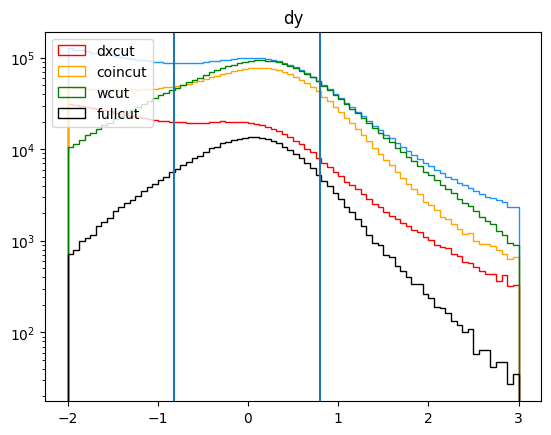

In [23]:
d=plt.hist(generic["dy"],bins=80,range=(-2,3),color='dodgerblue',histtype='step')
d=plt.hist(generic["dy"][dxcut],bins=80,range=(-2,3),color='red',label='dxcut',histtype='step')
d=plt.hist(generic["dy"][coincut],bins=80,range=(-2,3),color='orange',label='coincut',histtype='step')
d=plt.hist(generic["dy"][wcut],bins=80,range=(-2,3),color='green',label='wcut',histtype='step')
d=plt.hist(generic["dy"][dxcut&coincut&wcut],bins=80,range=(-2,3),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("dy")
plt.yscale("log")
plt.axvline(dymin)
plt.axvline(dymax)

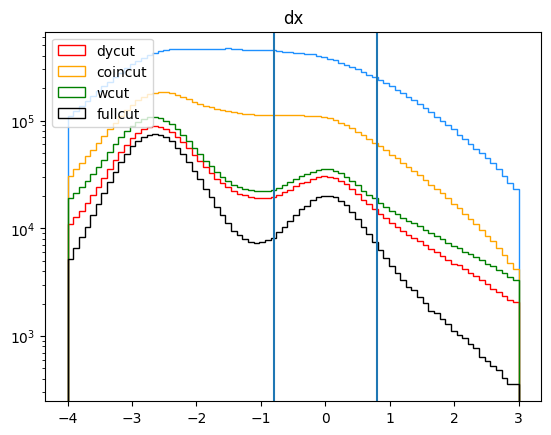

In [24]:
d=plt.hist(generic["dx"],bins=80,range=(-4,3),color='dodgerblue',histtype='step')
d=plt.hist(generic["dx"][dycut],bins=80,range=(-4,3),color='red',label='dycut',histtype='step')
d=plt.hist(generic["dx"][coincut],bins=80,range=(-4,3),color='orange',label='coincut',histtype='step')
d=plt.hist(generic["dx"][wcut],bins=80,range=(-4,3),color='green',label='wcut',histtype='step')
d=plt.hist(generic["dx"][dycut&coincut&wcut],bins=80,range=(-4,3),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("dx")
plt.yscale("log")
plt.axvline(dxmin)
plt.axvline(dxmax)

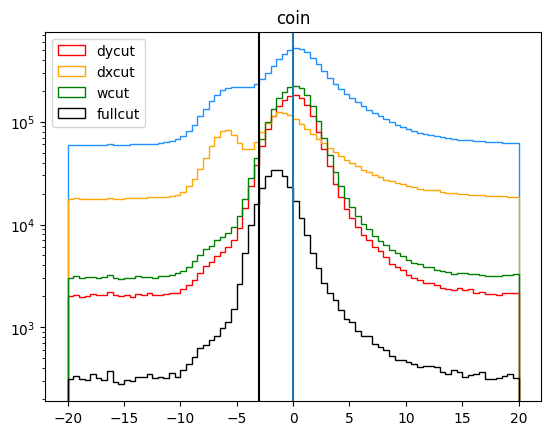

In [25]:
d=plt.hist(generic["coin_time"]-130,bins=80,range=(-20,20),color='dodgerblue',histtype='step')
d=plt.hist(generic["coin_time"][dycut]-130,bins=80,range=(-20,20),color='red',label='dycut',histtype='step')
d=plt.hist(generic["coin_time"][dxcut]-130,bins=80,range=(-20,20),color='orange',label='dxcut',histtype='step')
d=plt.hist(generic["coin_time"][wcut]-130,bins=80,range=(-20,20),color='green',label='wcut',histtype='step')
d=plt.hist(generic["coin_time"][dycut&wcut&dxcut]-130,bins=80,range=(-20,20),color='black',label='fullcut',histtype='step')
plt.legend(loc='upper left')
plt.title("coin")
plt.yscale("log")

new_coinmin=coinmin+6.5-5/2
new_coinmax=coinmax-6.5+5/2

plt.axvline(new_coinmin-130,color='black')
plt.axvline(new_coinmax-130)



In [26]:
new_coinmin

127.0

# Entire Analysis

In [23]:

def weighted_avg(values, errors):
    values = np.asarray(values)
    errors = np.asarray(errors)
    
    mask = (errors > 0) & np.isfinite(errors)
    if not np.any(mask):
        raise ValueError("No valid data points: all errors are zero, negative, or non-finite.")

    weights = 1 / errors[mask]**2
    avg = np.sum(values[mask] * weights) / np.sum(weights)
    err = np.sqrt(1 / np.sum(weights))
    
    return avg, err


In [24]:
def calculate_Aphys_with_error(epsilon_bar, tau_bar, Lambda, Px_bar, Pz_bar, dLambda):
    """
    Calculate A_phys and its uncertainty from Lambda.

    Parameters:
    epsilon_bar : float
    tau_bar : float
    Lambda : float
    Px_bar : float
    Pz_bar : float
    dLambda : float
        Uncertainty in Lambda

    Returns:
    A_phys : float
    dA_phys : float
        Uncertainty in A_phys
    """
    E = epsilon_bar
    T = tau_bar
    L = Lambda
    Px = Px_bar
    Pz = Pz_bar

    sqrt_term = np.sqrt((2 * E * (1 - E)) / T)
    denom = 1 + (E / T) * L**2
    num = L * sqrt_term * Px + np.sqrt(1 - E**2) * Pz

    A_phys = -num / denom

    # Derivatives for error propagation
    d_num_dL = sqrt_term * Px
    d_denom_dL = 2 * (E / T) * L

    dA_dLambda = -(d_num_dL * denom - num * d_denom_dL) / denom**2
    dA_phys = abs(dA_dLambda) * dLambda

    return A_phys, dA_phys

    mup=2.793
    Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
def load_data(file_path):
    """
    Load the data from the given file path into a pandas DataFrame.
    """
    columns = ["Q2", "GEp/GD", "dGEp/GD", "dGEp_Par/GD", "GMp/mu_p/GD", "dGMp/mu_p/GD", "dGMp_Par/mu_p/GD"]
    data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns)
    return data
def find_closest_row(data, input_Q2):
    """
    Find the row in the data with the Q2 value closest to the input_Q2.
    """
    closest_row = data.iloc[(data['Q2'] - input_Q2).abs().argmin()]
    return closest_row
def main(input_Q2):
    file_path = '../DB/proton_lookup.dat'
    data = load_data(file_path)
    closest_row = find_closest_row(data, input_Q2)
    return closest_row

def propagate_errorAP(Ap, dAp, Pp, dPp, P_beam, dP_beam, P_target, dP_target):
    f = (Ap * Pp * P_beam * P_target) 
    rel_error_squared = (
        (dAp / Ap)**2 +
        (dPp / Pp)**2 +
        (dP_beam / P_beam)**2 +
        (dP_target / P_target)**2
    )
    df = f * np.sqrt(rel_error_squared)
    return f, df

In [99]:

if config=="2":
    Lower=-3#-5
    Upper=2

else:
    Lower=-4
    Upper=2.5

def Function_Fitdx(wcut,dycut,dxcut,coincut,fullcutfordx,protoncut,
                  neutroncut,Simwcut,Simdycut,bgcut,weight):
    

    counts_p, bin_edges = np.histogram(genericSim["dx"][protoncut&Simwcut&Simdycut],   ####.065
                                       bins=80, range=(Lower, Upper),
                                       weights=weight[protoncut&Simwcut&Simdycut])

    counts_n, _         = np.histogram(genericSim["dx"][neutroncut&Simwcut&Simdycut],
                                       bins=bin_edges,
                                       weights=weight[neutroncut&Simwcut&Simdycut])
    #bgcut:  [bgcut&(goodsigmacut)]
    counts_bg,_         = np.histogram(dx_in[bgcut&(goodsigmacut)],
                                       bins=bin_edges,weights=sigma[bgcut&(goodsigmacut)])
    #counts_bg,_         = np.histogram(dx_in[bgcut&(goodsigmacut)],
    #                                   bins=bin_edges,weights=sigmaold[bgcut&(goodsigmacut)])
    #counts_bg,_         = np.histogram(generic["dx"][antibgcut],
     #                                  bins=bin_edges)

    counts_data, _      = np.histogram(generic["dx"][fullcutfordx], bins=bin_edges)


    counts_p = counts_p.astype(float)
    counts_n = counts_n.astype(float)
    counts_bg = counts_bg.astype(float)
    #counts_acc = counts_acc.astype(float)
    counts_data = counts_data.astype(float)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    shape=("from data")
    if config=="2":
        shape=("from data")
    fit_obj = DistributionFits(bg_shape_option=shape)
    fit_obj.hdx_data = [bin_centers, counts_data]
    fit_obj.hdx_sim_p = [bin_centers, counts_p]
    fit_obj.hdx_sim_n = [bin_centers, counts_n]
    fit_obj.hdx_bg_data = [bin_centers, counts_bg] 
    #fit_obj.hdx_acc_data = [bin_centers, counts_acc] 


    if shape=="from data+acc":
        bg_fit, total_fit, sim_p_scaled, sim_n_scaled,pop0,pop1,pop2,pop3,scale,acc_fit= fit_obj.He3_fit_dists(True)
    else:
        bg_fit, total_fit, sim_p_scaled, sim_n_scaled,pop0,pop1,pop2,scale= fit_obj.He3_fit_dists(True)

    return bg_fit,total_fit,sim_p_scaled,sim_n_scaled,bin_centers,counts_data
def Function_Plotdx(bg_fit,total_fit,sim_p_scaled,sim_n_scaled,bin_centers,counts_data,dxmin,dxmax):
    # Style config
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    fig, ax = plt.subplots(figsize=(10, 8))
    lw = 1.4
    l = 3
    fs = 16
    fw = 'bold'
    a = 1  # transparency for bars
    bin_width = bin_centers[1] - bin_centers[0]

    # Optional override
    if config == "2":
        lw = 1
        l = 3
        typ = "4th Order Poly"
    else:
        typ = "Background Data"



    # --------- Total Fit ---------hatch='///',
    ax.bar(bin_centers, total_fit, width=bin_width, align='center', alpha=0.7, color='orange', label="MC Fit = MC + Background")
    ax.plot(bin_centers, total_fit, '--', color='black', linewidth=lw)

    # --------- Inelastic ---------
    ax.bar(bin_centers, bg_fit, width=bin_width, align='center', alpha=0.7, color='magenta', label="MC Inelastic")
    ax.plot(bin_centers, bg_fit, '--', color='black', linewidth=lw)

    # --------- Accidental ---------
    #ax.bar(bin_centers, acc_fit, width=bin_width, align='center', alpha=0.5, color='magenta', label="MC Inelastic")
    #ax.plot(bin_centers, acc_fit, '--', color='black', linewidth=lw)

    # --------- Sim Proton ---------
    ax.bar(bin_centers, sim_p_scaled, width=bin_width, align='center', alpha=0.7, color='red', label="MC Proton")
    ax.plot(bin_centers, sim_p_scaled, '--', color='black', linewidth=lw)

    # --------- Sim Neutron ---------
    ax.bar(bin_centers, sim_n_scaled, width=bin_width, align='center', alpha=0.7, color='dodgerblue', label="MC Neutron")
    ax.plot(bin_centers, sim_n_scaled, '--', color='black', linewidth=lw)

    # --------- Data Line ---------
    ax.bar(bin_centers, counts_data, width=bin_width, align='center', alpha=.01, color='white',label="Data")
    ax.plot(bin_centers, counts_data, '-', color='grey',alpha=.8, linewidth=l, label='Data')

    # --------- Custom Legend ---------
    legend_elements = [
        Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
        Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
        Patch(facecolor='magenta', edgecolor='black', linestyle='--', label='MC Zheng Model', alpha=a),
        Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
        Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=fs)
    # --------- Labels, ticks, etc. ---------
    ax.set_title(f'Data/Simulation Comparison for GEN{config}: Δx (m)', fontsize=fs, fontweight=fw)
    ax.set_xlabel(r'$\Delta x$ (m)', fontsize=fs, fontweight=fw)
    ax.set_ylabel('Entries', fontsize=fs, fontweight=fw)
    ax.tick_params(axis='both', labelsize=fs-4)
    plt.xticks(fontsize=fs-4, fontweight=fw)
    plt.yticks(fontsize=fs-4, fontweight=fw)
    plt.tight_layout()
    #plt.yscale("log")
    plt.axvline(dxmin,color='black')
    plt.axvline(dxmax,color='black')
    # --------- Save and show ---------
    #plt.savefig(f'../plots/DataSimPass{pas}GEN{config}.png')
    plt.show()

    # Optional: Check total counts
    print("Total entries in fit:", np.sum(total_fit))


In [100]:

"""def Function_Acc(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin):
    
    wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
    dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
    dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
    hcalcut=generic["eHCAL"]>hcalmin
    accidentalcut=wcut&dycut&dxcut&epcut&runnumcut&hcalcut
    anticoincut=(coinmin-8 > generic["coin_time"])|(generic["coin_time"] > coinmax+5)
    
    accBinRange=100
    coin_hist,coin_edges=np.histogram(generic["coin_time"][accidentalcut],
                                      bins=200,range=(coinmin-accBinRange,coinmax+accBinRange))
    coin_centers= (coin_edges[:-1] + coin_edges[1:]) / 2


    outside_coin_right=(coin_centers >= coinmin+20) & (coin_centers <= coinmax+20)
    outside_coin_left=(coin_centers >= coinmin-20) & (coin_centers <= coinmax-20)
    inside_coin=(coin_centers >= coinmin) & (coin_centers <= coinmax)

    outside_number=(np.sum(coin_hist[outside_coin_right])+np.sum(coin_hist[outside_coin_left]))/2
    inside_number=(np.sum(coin_hist[inside_coin]))

    f_acc=outside_number/inside_number
    f_acc_error=f_acc * math.sqrt(1 / outside_number + 1 / inside_number)

    plus_coin_hist,plus_coin_edges=np.histogram(generic["coin_time"][anticoincut&accidentalcut&hpluscut],bins=100,range=(coinmin-30,coinmax+60))
    minus_coin_hist,minus_coin_edges=np.histogram(generic["coin_time"][anticoincut&accidentalcut&hminuscut],bins=100,range=(coinmin-30,coinmax+60))

    coin_plus_total = np.sum(plus_coin_hist)
    coin_minus_total = np.sum(minus_coin_hist)

    A_acc=(coin_plus_total-coin_minus_total)/(coin_plus_total+coin_minus_total)
    A_acc_error=2*math.sqrt(coin_plus_total * coin_minus_total) / (coin_plus_total + coin_minus_total)**(3/2)

    return f_acc,f_acc_error,A_acc,A_acc_error"""
    
def Function_Acc(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,psmin,epcut,ShowPlots=True):
    wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
    dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
    dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
    hcalcut=generic["eHCAL"]>hcalmin
    pscut=generic["ePS"]>psmin
    accidentalcut=wcut&dycut&dxcut&epcut&runnumcut&hcalcut&pscut&epcut
    anticoincut=(coinmin-8 > generic["coin_time"])|(generic["coin_time"] > coinmax+8)
    
    accBinRange=40
    #plt.figure(figsize=(8,6),dpi=200)
    coin_hist,coin_edges=np.histogram(generic["coin_time"][accidentalcut],
                                      bins=100,range=(coinmin-accBinRange,coinmax+accBinRange))
    coin_centers= (coin_edges[:-1] + coin_edges[1:]) / 2
    if ShowPlots:
        plt.figure(dpi=200)
        d=plt.hist(generic["coin_time"][accidentalcut],
                   bins=100,range=(coinmin-accBinRange,coinmax+accBinRange),color='orange',alpha=.4)
        plt.plot(coin_centers, coin_hist,'--',color='black',linewidth=1)

        plt.title(f"Cointime HCal-BBCal (ADC) GEN{config}")

        plt.axvline(coinmin,color='black')
        plt.axvline(coinmax,color='black')
        plt.axvspan(coinmin, coinmax, color='red', alpha=0.2)

        plt.axvline(coinmin+20,color='black')
        plt.axvline(coinmax+20,color='black')
        plt.axvspan(coinmin+20, coinmax+20, color='dodgerblue', alpha=0.3)

        plt.axvline(coinmin-20,color='black')
        plt.axvline(coinmax-20,color='black')
        plt.axvspan(coinmin-20, coinmax-20, color='dodgerblue', alpha=0.3)
        plt.xlabel("[ns]")

        #plt.yscale("log")
    outside_coin_right=(coin_centers >= coinmin+25) & (coin_centers <= coinmax+25)
    outside_coin_left=(coin_centers >= coinmin-25) & (coin_centers <= coinmax-25)
    inside_coin=(coin_centers >= coinmin) & (coin_centers <= coinmax)

    outside_number=(np.sum(coin_hist[outside_coin_right])+np.sum(coin_hist[outside_coin_left]))/2
    inside_number=(np.sum(coin_hist[inside_coin]))

    f_acc=outside_number/inside_number
    f_acc_error=f_acc * math.sqrt(1 / outside_number + 1 / inside_number)

    plus_coin_hist,plus_coin_edges=np.histogram(generic["coin_time"][anticoincut&accidentalcut&hpluscut],bins=100,range=(coinmin-30,coinmax+60))
    minus_coin_hist,minus_coin_edges=np.histogram(generic["coin_time"][anticoincut&accidentalcut&hminuscut],bins=100,range=(coinmin-30,coinmax+60))
    if ShowPlots:
        deez_hist,deez_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hcalcut&anticoincut],bins=100,
                range=(coinmin-30,coinmax+60))
        deez_centers= (deez_edges[:-1] + deez_edges[1:]) / 2
        plt.figure(dpi=200)
        plt.yscale("log")
        plt.title(f"Cointime HCal-BBCal (ADC) GEN{config}")
        plt.hist(generic["coin_time"][wcut&dycut&dxcut&hcalcut&anticoincut],bins=100,
                range=(coinmin-30,coinmax+60),color="dodgerblue",alpha=.5,label="Asymmetry Region")
        plt.plot(deez_centers, deez_hist,'--',color='black',linewidth=1)
        plt.xlabel("[ns]")
        deez_hist,deez_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hcalcut&coincut],bins=100,
                range=(coinmin-30,coinmax+60))
        deez_centers= (deez_edges[:-1] + deez_edges[1:]) / 2
        plt.hist(generic["coin_time"][wcut&dycut&dxcut&hcalcut&coincut],bins=100,
                range=(coinmin-30,coinmax+60),color="orange",alpha=.5,label="Coincidence Region")
        plt.plot(deez_centers, deez_hist,'--',color='black',linewidth=1)
        plt.legend(loc='upper right')
        
        plt.figure(dpi=200)
        plt.title(f"Cointime HCal-BBCal (ADC) GEN{config}")
        plt.xlabel("[ns]")
        deez_hist,deez_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hcalcut],bins=100,
                range=(coinmin-15,coinmax+15))
        deez_centers= (deez_edges[:-1] + deez_edges[1:]) / 2
        plt.hist(generic["coin_time"][wcut&dycut&dxcut&hcalcut],bins=100,
                range=(coinmin-15,coinmax+15),color="orange",alpha=.5)
        plt.plot(deez_centers, deez_hist,'--',color='black',linewidth=1)
    coin_plus_total = np.sum(plus_coin_hist)
    coin_minus_total = np.sum(minus_coin_hist)

    A_acc=(coin_plus_total-coin_minus_total)/(coin_plus_total+coin_minus_total)
    A_acc_error=2*math.sqrt(coin_plus_total * coin_minus_total) / (coin_plus_total + coin_minus_total)**(3/2)
    #print(f"N_plus: {coin_plus_total} N_minus: {coin_minus_total}")
    #print(f"f_acc: {f_acc:.4f}+={f_acc_error:.4f} A_acc: {A_acc:.6f}+-{A_acc_error:.4f}")
    return f_acc,f_acc_error,A_acc,A_acc_error

In [101]:
def Function_Proton(f_p,f_p_error):
    mup=2.793
    Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
    def load_data(file_path):
        """
        Load the data from the given file path into a pandas DataFrame.
        """
        columns = ["Q2", "GEp/GD", "dGEp/GD", "dGEp_Par/GD", "GMp/mu_p/GD", "dGMp/mu_p/GD", "dGMp_Par/mu_p/GD"]
        data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns)
        return data
    def find_closest_row(data, input_Q2):
        """
        Find the row in the data with the Q2 value closest to the input_Q2.
        """
        closest_row = data.iloc[(data['Q2'] - input_Q2).abs().argmin()]
        return closest_row
    def main(input_Q2):
        file_path = '../DB/proton_lookup.dat'
        data = load_data(file_path)
        closest_row = find_closest_row(data, input_Q2)
        return closest_row
    row=main(Q2)
    R=np.round(row[1]/row[4]/mup,4)


    #in GeV^2

    def Aperp(R, tau, theta):
        tan_half_theta = np.tan(np.radians(theta) / 2)
        numerator = -R * 2 * np.sqrt(tau * (tau + 1)) * tan_half_theta
        denominator = R**2 + (tau + 2 * tau * (1 + tau) * tan_half_theta**2)
        A_perp = numerator / denominator
        return A_perp

    Ap=Aperp(R,tau,theta)
    P_p=-.04 # seamus thesis
    P_beam=CONFIG.Function_JSON("Pbeam",f"../config/cuts{config}.cfg")
    P_target=CONFIG.Function_JSON("Ptarget",f"../config/cuts{config}.cfg")

    A_p=Ap*P_p*P_beam*P_target/100/100
    #Aphys_p=Ap*P_p*P_beam*P_target/100/100
    #print(f"f_p: {f_p:.4f}+={f_p_error:.4f} A_p: {A_p:.7f}")
    return A_p

In [102]:
def Function_Inelastic(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin):
    #hcalcut=generic["eHCAL"]>hcalmin

    antibgcut=(abs(generic["dy"])>1.2)&wcut&coincut
    antibgAcut=(abs(generic["dy"])>2)&wcut&coincut

    accBinRange=100
    #plt.figure(figsize=(8,6),dpi=200)
    inhist,coin_edges=np.histogram(generic["dx"][antibgcut],
                                      bins=200,range=(-4,3))
    coin_centers= (coin_edges[:-1] + coin_edges[1:]) / 2
    #d=plt.hist(generic["dx"][antibgcut],
    #                                  bins=200,range=(-4,3))


    plus_in_hist,plus_in_edges=np.histogram(generic["dx"][antibgAcut&hpluscut],bins=100,range=(dxmin,dxmax))
    minus_in_hist,minus_in_edges=np.histogram(generic["dx"][antibgAcut&hminuscut],bins=100,range=(dxmin,dxmax))

    in_plus_total = np.sum(plus_in_hist)
    in_minus_total = np.sum(minus_in_hist)
    #print(in_plus_total,in_minus_total)
    A_in=(in_plus_total-in_minus_total)/(in_plus_total+in_minus_total)
    A_in_error=2*math.sqrt(in_plus_total * in_minus_total) / (in_plus_total + in_minus_total)**(3/2)
    #print(f"N_plus: {coin_plus_total} N_minus: {coin_minus_total}")
    #print(f"f_acc: {f_acc:.4f}+={f_acc_error:.4f} A_acc: {A_acc:.6f}+-{A_acc_error:.4f}")
    return A_in,A_in_error

In [118]:
def Function_N2():
    hdx_sim_n=np.histogram(genericSim["dx"],range=(-.4,.4),
                       bins=100)
    he3simfrac=np.sum(hdx_sim_n[0])/len(genericSim["dx"])


    #the sim fraction
    n2simfrac=135874/268774

    n2overhe3counts=n2simfrac/he3simfrac/14 # divide by 14 because nitrogen molecule has 14 times n

    n2overhe3counts

    1.5*14*n2overhe3counts
    98.5

    nAtoms=100
    nN2=.015
    nHe3=.985

    f_n2=nN2*14/(14*nN2+nHe3)*n2overhe3counts
    
    f_n2=.0267 #CALCULATED IN NITROGEN CORRECTION NOTEBOOK
    f_n2_error=.02*f_n2
    
    
    return f_n2,f_n2_error

In [119]:
def ShowW2(dxcut,dycut,coincut,Simdycut,Simdxcut,InSimdycut,InSimdxcut,f_n,f_bg,f_p,W2min,W2max):
    neutronW2=neutroncut&Simdycut&Simdxcut
    protonW2=protoncut&Simdycut&Simdxcut
    bgW2=InSimdycut&InSimdxcut&goodsigmacut
    dataW2=dycut&dxcut&coincut
    # Data (no scaling/normalization for raw data)
    hist_data = plt.hist(generic["W2"][dataW2], bins=100, range=(W2min, W2max), color='black')
    counts_data, bins_data = hist_data[0], hist_data[1]
    scale=np.sum(counts_data)

    # Sim proton
    hist_p = plt.hist(genericSim["W2"][protonW2], bins=100,weights=weight[protonW2], range=(W2min, W2max), color='dodgerblue', alpha=0.5)
    counts_p, bins_p = hist_p[0], hist_p[1]
    norm_counts_p = counts_p / np.sum(counts_p)
    scaled_counts_p = norm_counts_p *(f_p)

    # Sim neutron
    hist_n = plt.hist(genericSim["W2"][neutronW2], bins=100, weights=weight[neutronW2],range=(W2min, W2max), color='red', alpha=0.5)
    counts_n, bins_n = hist_n[0], hist_n[1]
    norm_counts_n = counts_n / np.sum(counts_n)
    scaled_counts_n = norm_counts_n * (f_n)

    # Background
    hist_bg = plt.hist(genericSimIN["W2"][goodsigmacut], bins=100,weights=sigma[goodsigmacut], range=(W2min, W2max), color='orange', alpha=0.5)
    counts_bg, bins_bg = hist_bg[0], hist_bg[1]
    norm_counts_bg = counts_bg / np.sum(counts_bg)
    scaled_counts_bg = norm_counts_bg * (f_bg)


    # Bin centers
    bin_centers_p = 0.5 * (bins_p[1:] + bins_p[:-1])
    bin_centers_n = 0.5 * (bins_n[1:] + bins_n[:-1])
    bin_centers_bg = 0.5 * (bins_bg[1:] + bins_bg[:-1])
    bin_centers_data = 0.5 * (bins_data[1:] + bins_data[:-1])

    # Plot
    plt.figure(dpi=200)
    plt.step(bin_centers_p, scaled_counts_p*scale, where='mid', color='red', label='Proton Sim')
    plt.step(bin_centers_n, scaled_counts_n*scale, where='mid', color='dodgerblue', label='Neutron Sim')
    plt.step(bin_centers_bg, scaled_counts_bg*scale, where='mid', color='orange', label='BG Distribution')
    plt.step(bin_centers_data, counts_data, where='mid', color='black', label='Data')
    plt.step(bin_centers_data, scaled_counts_p*scale+scaled_counts_n*scale+scaled_counts_bg*scale, where='mid', color='grey', label='Sum of Sim')
    
    plt.title(f"W$^2$ GEN{config}")
    plt.xlabel(r"W$^2$ [GeV$^2$]")
    plt.ylabel("Counts (scaled)")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, np.max(counts_data)*1.1)
    plt.show()
    return

In [129]:
def DoItAll(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,
            psmin,epmin,printStats=True,printPlot=True):
    
    #print(W2min,W2max,dxmin,dxmax,
    #     dymin,dymax,coinmin,coinmax)
    #print(W2max)
    bbcalE=generic["eSH"]+generic["ePS"]
    gemP=generic["trP"]
    wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
    dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
    dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
    coincut=(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)
    hcalecut=(generic["eHCAL"])>hcalmin
    epcut=bbcalE/gemP>epmin
    pscut=generic["ePS"]>psmin
    runnumcut=generic["runnum"]>2165

    fullcut=wcut&dycut&dxcut&coincut&epcut&runnumcut&hcalecut&hcalecut&pscut
    fullcutfordx=wcut&dycut&coincut&epcut&runnumcut&hcalecut&hcalecut&pscut
    accidentalcut=wcut&dycut&dxcut&epcut&runnumcut&hcalecut&hcalecut&pscut
    weight=genericSim["weight"]
    bgcut=(W2_in<W2max)&(W2_in>W2min)
    Simwcut=(genericSim["W2"] < W2max)&(genericSim["W2"]>W2min) 
    Simdycut=(genericSim["dy"]<dymax)&(genericSim["dy"]>dymin)
    InSimdxcut=(genericSimIN["dx"] < dxmax)&(genericSimIN["dx"]>dxmin)
    InSimdycut=(genericSimIN["dy"] < dymax)&(genericSimIN["dy"]>dymin)
    
    FitResult=Function_Fitdx(wcut,dycut,dxcut,
                            coincut,fullcutfordx,protoncut,
                            neutroncut,Simwcut,Simdycut,bgcut,weight)
   
    
    
    bg_fit=FitResult[0]
    total_fit=FitResult[1]
    sim_p_scaled=FitResult[2]
    sim_n_scaled=FitResult[3]
    bin_centers=FitResult[4]
    counts_data=FitResult[5]
    mask = (bin_centers >= dxmin) & (bin_centers <= dxmax)

    # Sum the corresponding bin contents
    N_p  = np.sum(sim_p_scaled[mask])
    N_n  = np.sum(sim_n_scaled[mask])
    N_bg = np.sum(bg_fit[mask])
    N_total = np.sum(total_fit[mask])
    N_total = np.sum(counts_data[mask])

    


    f_p=N_p/N_total
    f_bg=N_bg/N_total
    f_n=N_n/N_total
    f_p_error=f_p * math.sqrt(1 / N_p + 1 / N_total)
    f_bg_error=f_bg* math.sqrt(1 / N_bg + 1 / N_total)
    f_n_error=f_n* math.sqrt(1 / N_n + 1 / N_total)
    f_acc,f_acc_error,A_acc,A_acc_error=Function_Acc(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,
                                                    psmin,epcut)
    A_p=Function_Proton(f_p,f_p_error)
    f_nitrogen,f_nitrogen_error=Function_N2()
    
    if printPlot:
        Function_Plotdx(FitResult[0],FitResult[1],FitResult[2],FitResult[3],FitResult[4],FitResult[5],dxmin,dxmax)
        ShowW2(dxcut,dycut,coincut,Simdycut,Simdxcut,InSimdycut,InSimdxcut,f_n,f_bg,f_p,W2min,W2max)
    
    #temp below
    A_inelastic=0 #-.0075 
    A_inelastic_error=.0005 
    #A_inelastic,A_inelastic_error=Function_Inelastic(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin)
    #print("A, Ae: ",A_inelastic,A_inelastic_error)
#ARAW  #SWAPPED
    N_minus_raw=len(np.where(helicity[fullcut]==1)[0])
    N_plus_raw=len(np.where(helicity[fullcut]==-1)[0])
    #SEAN JEFFAS KIN3: N_minus_raw=20336
    #SEAN JEFFAS KIN3: N_plus_raw=21224
    #SEAN JEFFAS fN=.29
    #SEAN JEFFAS NEUTRONS: 12052.4
    NEUTRONSSSSS=f_n*(N_minus_raw+N_plus_raw)
    A_raw=(N_plus_raw-N_minus_raw)/(N_plus_raw+N_minus_raw)
    A_raw_error=2*math.sqrt(N_plus_raw * N_minus_raw) / (N_plus_raw + N_minus_raw)**(3/2)
    
    
    
#FILTER HELICITY    
    runs_filtered = generic["runnum"][fullcut]
    helicity_filtered = helicity[fullcut]
    # Now apply the run number cut:
    valid_runs = runs_filtered > 2165
    runs_filtered = runs_filtered[valid_runs]
    helicity_filtered = helicity_filtered[valid_runs]
    
#ARAW PER RUN #SWAPPED
    pluscut = helicity_filtered == -1
    minuscut = helicity_filtered == 1
    unique_runnum, run_idx = np.unique(runs_filtered, return_inverse=True)
    N_plus_per_run = np.bincount(run_idx, weights=pluscut.astype(int))
    N_minus_per_run = np.bincount(run_idx, weights=minuscut.astype(int))
    
   #CHECK FOR SAFE N VALUES
    A_raw_per_run = np.full_like(N_plus_per_run, np.nan, dtype=float)
    A_raw_error_per_run = np.full_like(N_plus_per_run, np.nan, dtype=float)
    valid = (N_plus_per_run > 0) & (N_minus_per_run > 0)
    denominator = (N_plus_per_run + N_minus_per_run)[valid]
    A_raw_per_run[valid] = (N_plus_per_run[valid] - N_minus_per_run[valid]) / denominator
    A_raw_error_per_run[valid] = 2 * np.sqrt(N_plus_per_run[valid] * N_minus_per_run[valid]) / denominator**1.5

    
    A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
    A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5
    A_raw_error_per_run=A_raw_error_per_run[~np.isnan(A_raw_per_run)]
    unique_runnum=unique_runnum[~np.isnan(A_raw_per_run)]
    A_raw_per_run=A_raw_per_run[~np.isnan(A_raw_per_run)]
    matching_pol_runs_i = np.searchsorted(target_run_num, unique_runnum)    
    P_beam_per_run = beam_pol[matching_pol_runs_i]/100
    P_beamE_per_run = beam_polE[matching_pol_runs_i]/100
    P_target_per_run = target_pol[matching_pol_runs_i]/100
    P_targetE_per_run = target_polE[matching_pol_runs_i]/100
    weightedaverage,weightedaverageE=weighted_avg(A_raw_per_run,A_raw_error_per_run)
    #print(P_target_per_run)
    #print(P_targetE_per_run)
    
    
#APHYS 
    f_inelastic=f_bg-f_acc-f_nitrogen
    if f_inelastic<0:
        print("Negative Fraction!")
        f_inelastic=0
    f_inelastic_error=np.sqrt(f_acc_error**2+f_bg_error**2)
    fA=f_acc*A_acc + f_inelastic*A_inelastic + f_p*A_p
    f=f_acc+f_nitrogen+f_p+f_inelastic
    P_neutron = 0.95 
    A_corrected_per_run = (A_raw_per_run - fA) / (1 - f)
    f_neutron=(1-f)
    A_phys_per_run = A_corrected_per_run / (P_beam_per_run * P_target_per_run * P_neutron)
    statistical_error_per_run=A_raw_error_per_run/(P_beam_per_run * P_target_per_run * P_neutron*f_neutron)
    A_Phys_wavg,A_Phys_wavgE=weighted_avg(A_phys_per_run,statistical_error_per_run)
    
    
#Target and Beam
    P_target_avg,_ =weighted_avg(P_target_per_run,statistical_error_per_run)
    P_beam_avg,_ =weighted_avg(P_beam_per_run,statistical_error_per_run)
    P_target_error_avg,_ =weighted_avg(P_targetE_per_run,statistical_error_per_run)
    P_beam_error_avg,_ =weighted_avg(P_beamE_per_run,statistical_error_per_run)
    
    #plt.hist(P_targetE_per_run/P_target_per_run*100,bins=30)
    
    
#PROTON+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    goodhel=(helicity[fullcut]==1) | (helicity[fullcut]==-1)

    Q2_avg=np.mean(generic["Q2"][fullcut][goodhel])
    etheta_avg=np.mean(generic["etheta"][fullcut][goodhel])

    tau_avg=Q2_avg/(4*m**2)

    epsilon_avg=1/(1+2*(1+tau_avg)*math.tan(etheta_avg/2)**2)

    
    trPx = generic["trPx"][fullcut][goodhel]
    trPy = generic["trPy"][fullcut][goodhel]
    trPz = generic["trPz"][fullcut][goodhel]
    ebeam = generic["ebeam"][fullcut][goodhel]

    Px,Pz=compute_Px_Pz(trPx,trPy,trPz,ebeam,spintheta,spinphi)
    Px_avg=np.mean(Px)
    Pz_avg=np.mean(Pz)
   





    row=main(Q2_avg)
    R=np.round(row[1]/row[4]/mup,4)
    RE=R/mup*np.sqrt((row[2]/row[1])**2+(row[5]/row[4])**2)
    Ap,A_p_e=calculate_Aphys_with_error(epsilon_avg, tau_avg, R, Px_avg, Pz_avg,RE)
    P_p=-.03 # seamus thesis


    #A_p=Ap*P_p*P_beam_avg*P_target_avg
    A_p,A_p_sig=propagate_errorAP(Ap, A_p_e, P_p, 0, P_beam_avg, P_beam_error_avg, P_target_avg, P_target_error_avg)
    
#PROTON+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Error prop

    f1=f_acc
    sig_f1=f_acc_error

    A1=A_acc
    sig_A1=A_acc_error

    f2=f_p
    sig_f2=f_p_error

    A2=A_p
    sig_A2=A_p_sig

    f3=f_inelastic
    sig_f3=f_inelastic_error
    A3=A_inelastic
    sig_A3=A_inelastic_error

    f4=f_nitrogen
    sig_f4=f_nitrogen_error

    Pb=P_beam_avg
    sig_Pb=P_beam_error_avg
    Pt=P_target_avg
    sig_Pt=P_target_error_avg
    #sig_Pt=0
    Pn=P_neutron

    P_total=Pb*Pt*Pn
    sig_P_total = ((sig_Pb / Pb)**2 + (sig_Pt / Pt)**2)**0.5

    fn=1-f1-f2-f3-f4
    #print(fn)
    A = A_Phys_wavg
    P=P_total
    
    dAdf1=((A*P-A1)/(P*fn)*sig_f1)**2
    dAdf2=((A*P-A2)/(P*fn)*sig_f2)**2
    dAdf3=((A*P-A3)/(P*fn)*sig_f3)**2
    dAdf4=((A*P)/(P*fn)*sig_f4)**2

    dAdA1=(f1/(P*fn)*sig_A1)**2
    dAdA2=(f2/(P*fn)*sig_A2)**2
    dAdA3=(f3/(P*fn)*sig_A3)**2

    #dAdP=(A/P**2*sig_P_total)**2
    dAdP=(A*sig_P_total)**2

    A_phys_sys_error=(dAdf1+dAdf2+dAdf3+dAdf4+dAdA1+dAdA2+dAdA3+dAdP)**(1/2)
    A_phys_stat_error=A_Phys_wavgE
    A_phys_comb_error=np.sqrt(A_phys_sys_error**2+A_phys_stat_error**2)

    
    total_var = dAdf1 + dAdf2 + dAdf3 + dAdf4 + dAdA1 + dAdA2 + dAdA3 + dAdP
    rel_contribs = {
        "f_acc": 100*dAdf1 / total_var,
        "f_p": 100*dAdf2 / total_var,
        "f_inelastic": 100*dAdf3 / total_var,
        "f_N2": 100*dAdf4 / total_var,
        "A_acc": 100*dAdA1 / total_var,
        "A_p": 100*dAdA2 / total_var,
        "A_inelastic": 100*dAdA3 / total_var,
        "P": 100*dAdP / total_var
    }

    """    print("A =", A)
    print("P =", P)
    print("σ_P =", sig_P_total)
    print("term =", (A / P**2) * sig_P_total)"""

    
    
    goodhel=(helicity[fullcut]==1) | (helicity[fullcut]==-1)
    Q2_avg=np.mean(generic["Q2"][fullcut][goodhel])
    etheta_avg=np.mean(generic["etheta"][fullcut][goodhel])
    tau_avg=Q2_avg/(4*m**2)
    epsilon_avg=1/(1+2*(1+tau_avg)*math.tan(etheta_avg/2)**2)
    
    
    trPx = generic["trPx"][fullcut][goodhel]
    trPy = generic["trPy"][fullcut][goodhel]
    trPz = generic["trPz"][fullcut][goodhel]
    ebeam = generic["ebeam"][fullcut][goodhel]
    Px,Pz=compute_Px_Pz(trPx,trPy,trPz,ebeam,spintheta,spinphi)
    Px_avg=np.mean(Px)
    Pz_avg=np.mean(Pz)
    
    
    
    A=epsilon_avg/tau_avg*A_Phys_wavg
    B=np.sqrt((2*epsilon_avg)*(1-epsilon_avg)/tau_avg)*Px_avg
    C=A_Phys_wavg+np.sqrt(1-epsilon_avg**2)*Pz_avg

    A_error_stat = (epsilon_avg / tau_avg) * A_phys_stat_error
    C_error_stat = A_phys_stat_error
    A_error_sys = (epsilon_avg / tau_avg) * A_phys_sys_error
    C_error_sys = A_phys_sys_error

    # Results
    
    ratio=(-B+np.sqrt(B**2-4*A*C))/(2*A)
    discriminant = B**2 - 4*A*C
    ratio_error_stat = np.sqrt(((C / (A * np.sqrt(discriminant)) + ratio / A)**2) * A_error_stat**2 + (C_error_stat**2 / discriminant))
    ratio_error_sys = np.sqrt(((C / (A * np.sqrt(discriminant)) + ratio / A)**2) * A_error_sys**2 + (C_error_sys**2 / discriminant))
    
    if printStats:
        print(f"Total events in range ({dxmin}, {dxmax}):")
        print(f"  Sim Proton:   {N_p:.2f}")
        print(f"  Sim Neutron:  {N_n:.2f}")
        print(f"  Background:   {N_bg:.2f}")
        print(f"  Total:        {N_total:.2f}")
        print(f"Fraction of events in range ({dxmin}, {dxmax}):")
        print(f"   Proton Fraction: {f_p:.2f}")
        print(f"   Background Fraction: {f_bg:.2f}")
        print(f"   Neutron Fraction: {f_n:.2f}") 
        print("__________________________________________________")
        print(f"Target Weighted Avg: {P_target_avg:.3}+-{P_target_error_avg:.4f}  {100*P_target_error_avg/P_target_avg:.4f}%")
        print(f"Beam Weighted Avg: {P_beam_avg:.3}+-{P_beam_error_avg:.4f}  {100*P_beam_error_avg/P_beam_avg:.4f}%")

        print("__________________________________________________")
        print(f"epsilon = {epsilon_avg:.4f}")
        print(f"tau_avg = {tau_avg:.4f}")
        print(f"Q2 = {Q2_avg:.4f}")
        print(f"Px: {Px_avg:.4f} Pz: {Pz_avg:.4f}")
        print(f"A = {A:.5f} ± {A_error_stat:.5f} ± {A_error_sys:.5f}")
        print(f"B = {B:.5f} (no propagated error)")
        print(f"C = {C:.5f} ± {C_error_stat:.5f} ± {C_error_sys:.5f}")

        print("__________________________________________________")

        print(f"N_plus: {N_plus_raw} N_minus: {N_minus_raw}")
        print(f"A_raw: {A_raw:.4f}+={A_raw_error:.4f}")
        print(f"A_raw_weighted: {weightedaverage:.3}+-{weightedaverageE:.4f}  {100*weightedaverageE/weightedaverage:.4f}%")

        print("__________________________________________________")
        print(f"A_phys_weighted: {A_Phys_wavg:.3}")
        print(f"A_phys_stat_error: {A_Phys_wavgE:.4f}  {A_Phys_wavgE/A_Phys_wavg*100:.4f}%")
        print(f"A_phys_sys_error: {A_phys_sys_error:.4f}  {A_phys_sys_error/A_Phys_wavg*100:.4}%")
        print(f"GEn/GMn*muN_stat_error: {ratio_error_stat*muN:.5f}  {abs(ratio_error_stat/ratio)*100:.4f}%")
        print(f"GEn/GMn*muN_phys_sys_error: {ratio_error_sys*muN:.5f}  {abs(ratio_error_sys/ratio)*100:.4}%")
        print(f"GEn/GMn*muN: {ratio*muN:.5f}+-{ratio_error_stat*muN:.5f}+-{ratio_error_sys*muN:.5f}")

    statdict = {
        "N_p": N_p,
        "N_n": N_n,
        "N_bg": N_bg,
        "N_total": N_total,
        "f_p": f_p,
        "f_p_e":f_p_error,
        "f_bg": f_bg,
        "f_bg_e": f_bg_error,
        "f_n": f_n,
        "f_n_e":f_n_error,
        "f_nitrogen":f_nitrogen,
        "f_nitrogen_e":f_nitrogen_error,
        "f_acc":f_acc,
        "f_acc_e":f_acc_error,
        "A_acc": A_acc,
        "A_acc_e":A_acc_error,
        "A_p":A_p,
        "A_p_e":A_p_sig,
        "A_inelastic":A_inelastic,
        "A_inelastic_e":A_inelastic_error,
        "P_beam":P_beam_avg,
        "P_beam_e":P_beam_error_avg,
        "P_target":P_target_avg,
        "P_target_e":P_target_error_avg,
        "N_plus_raw": N_plus_raw,
        "N_minus_raw": N_minus_raw,
        "A_raw": A_raw,
        "A_raw_rel_error": A_raw_error / A_raw,
        "A_Phys_wavg": A_Phys_wavg,
        "A_phys_rel_sys_error": A_phys_sys_error / A_Phys_wavg,
        "A_phys_rel_sat_error": A_Phys_wavgE / A_Phys_wavg,
        "tau":tau_avg,
        "epsilon":epsilon_avg,
        "Q2":Q2_avg,
        "Px":Px_avg,
        "Pz":Pz_avg,
        "GE/GM * muN": ratio * muN,
        "GE/GM_stat_error": abs(ratio_error_stat * muN),
        "GE/GM_sys_error": abs(ratio_error_sys * muN)
    }

    
    return rel_contribs,total_var, statdict,Q2_avg
    

In [130]:
##Kin2

"""new_W2min=.87-9/10
new_W2max=.88+9/20
new_dxmin=-.1-10/20
new_dxmax=.1+10/20
new_dymin=-.1-5/10
new_dymax=.1+5/10

new_coinmin=coinmin+6.5-5/2
new_coinmax=coinmax-5.5+5/2"""

new_W2min=.87-8/10
new_W2max=.88+8/20
new_dxmin=-.1-17/20
new_dxmax=.1+17/20
new_dymin=-.1-6/10
new_dymax=.1+6/10
psmin=.2
epmin=.7
new_coinmin=coinmin+6.5-7/2
new_coinmax=coinmax-6.5+7/2


In [131]:
print(f"{new_W2min:.4f}")
print(f"{new_W2max:.4f}")
print(f"{new_dxmin:.4f}")
print(f"{new_dxmax:.4f}")
print(f"{new_dymin:.4f}")
print(f"{new_dymax:.4f}")
print(f"{new_coinmin:.4f}")
print(f"{new_coinmax:.4f}")


0.0700
1.2800
-0.9500
0.9500
-0.7000
0.7000
126.0000
131.0000


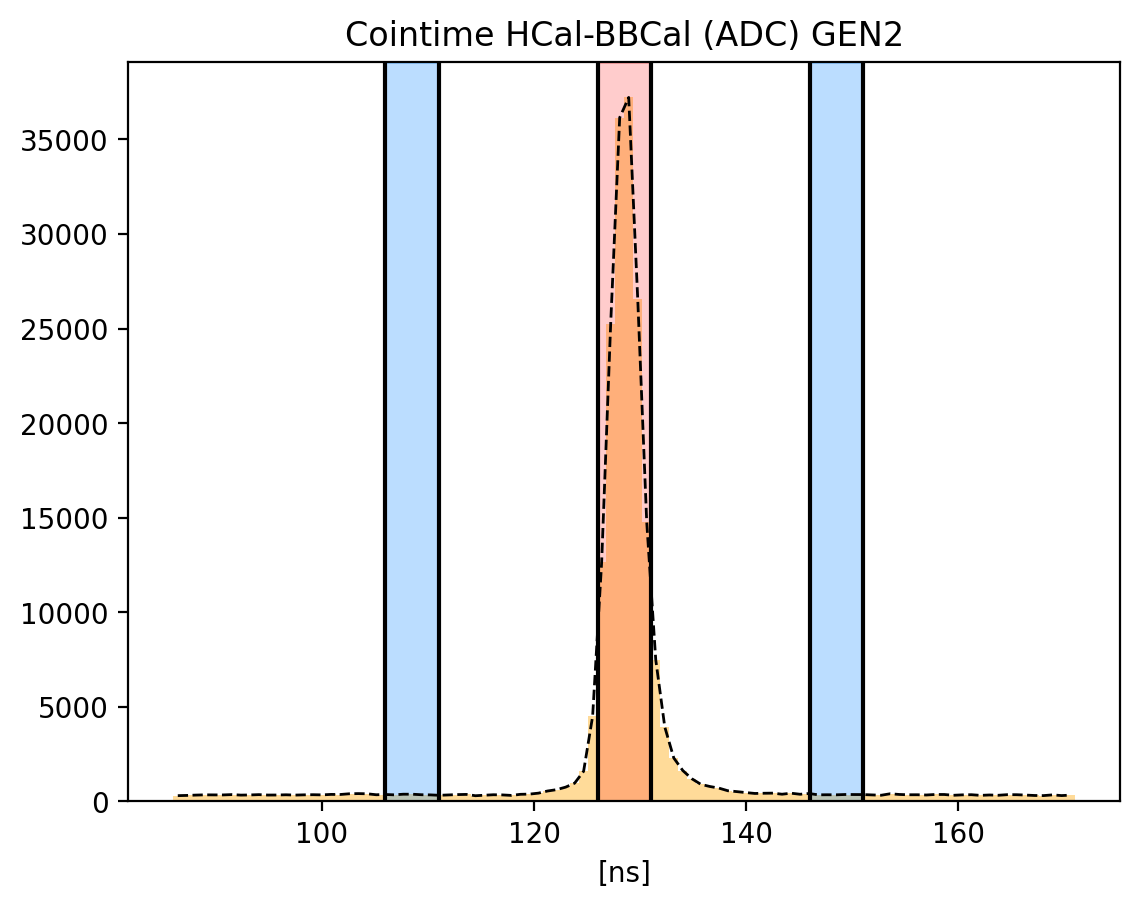

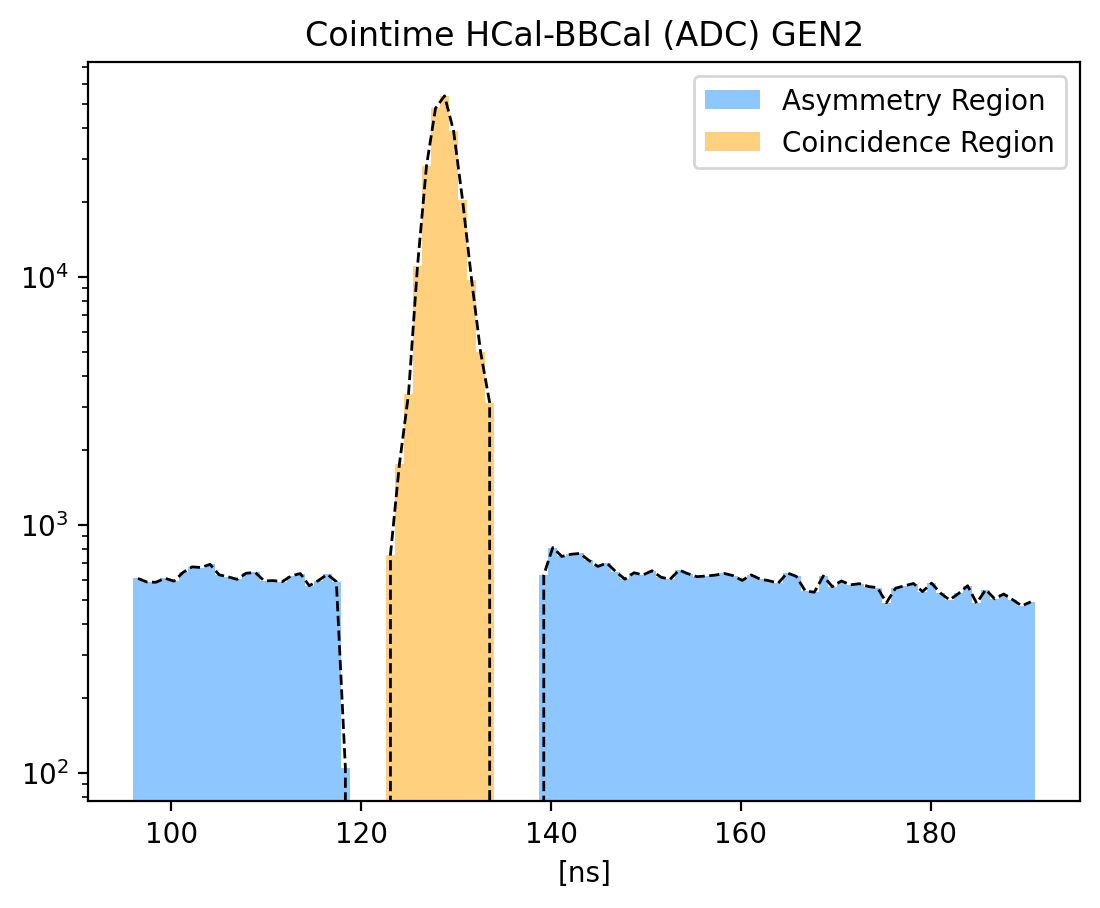

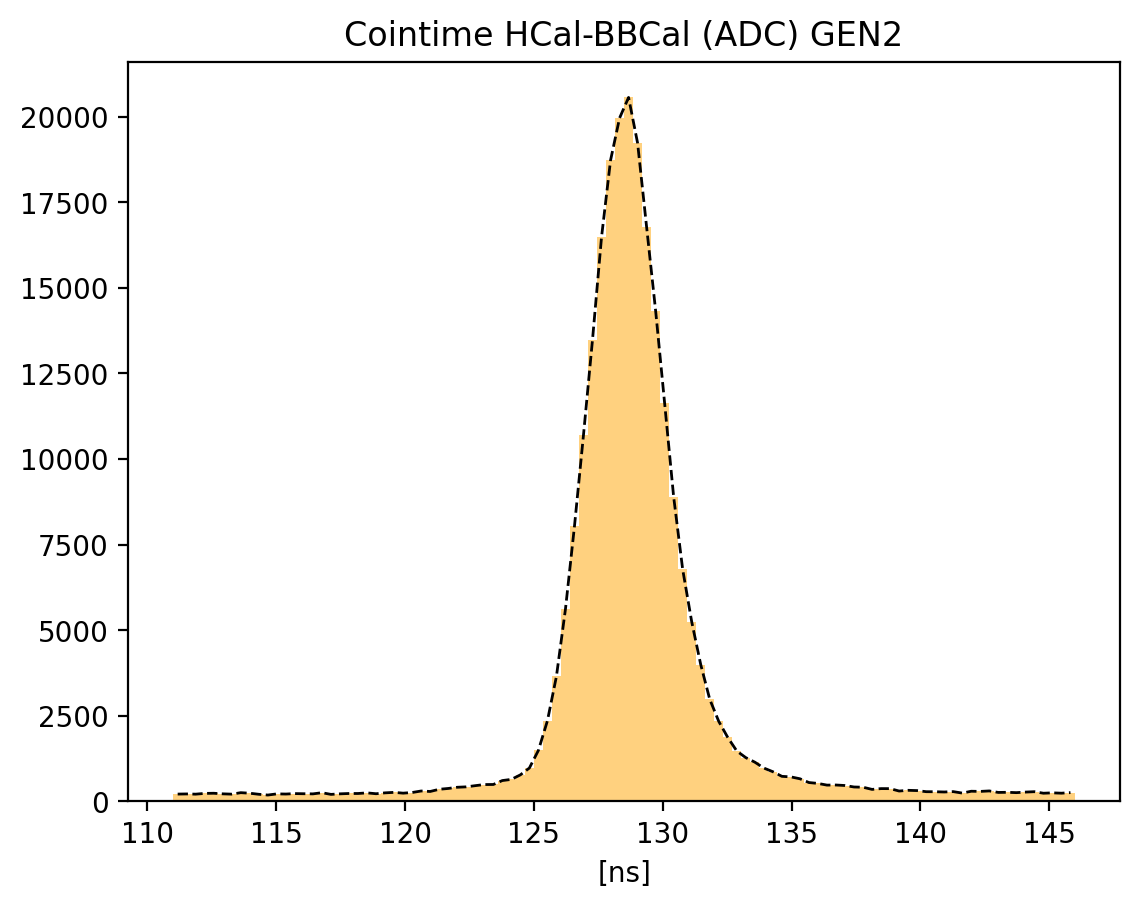

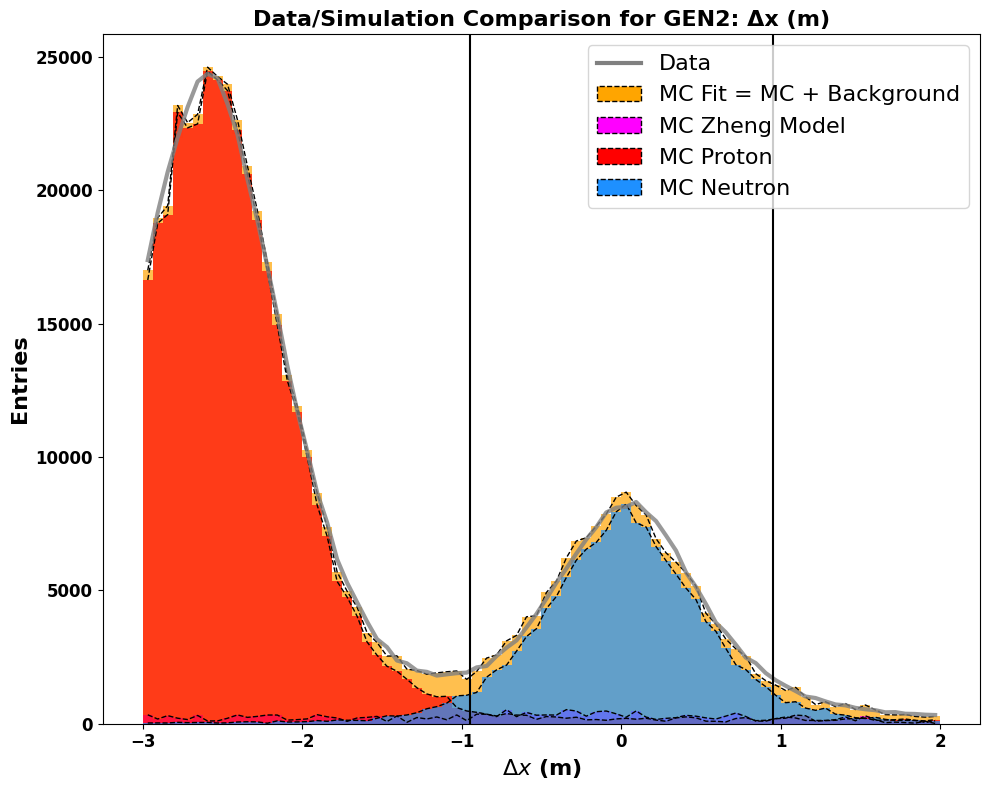

Total entries in fit: 545607.279050682


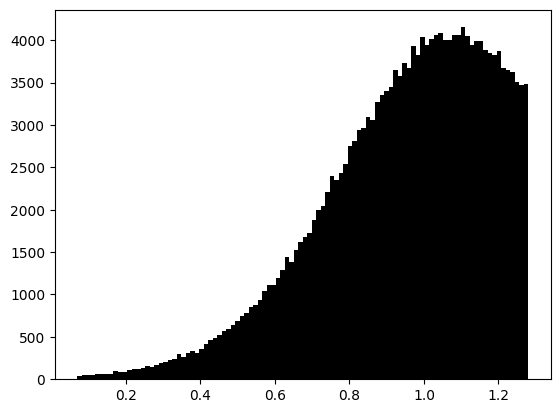

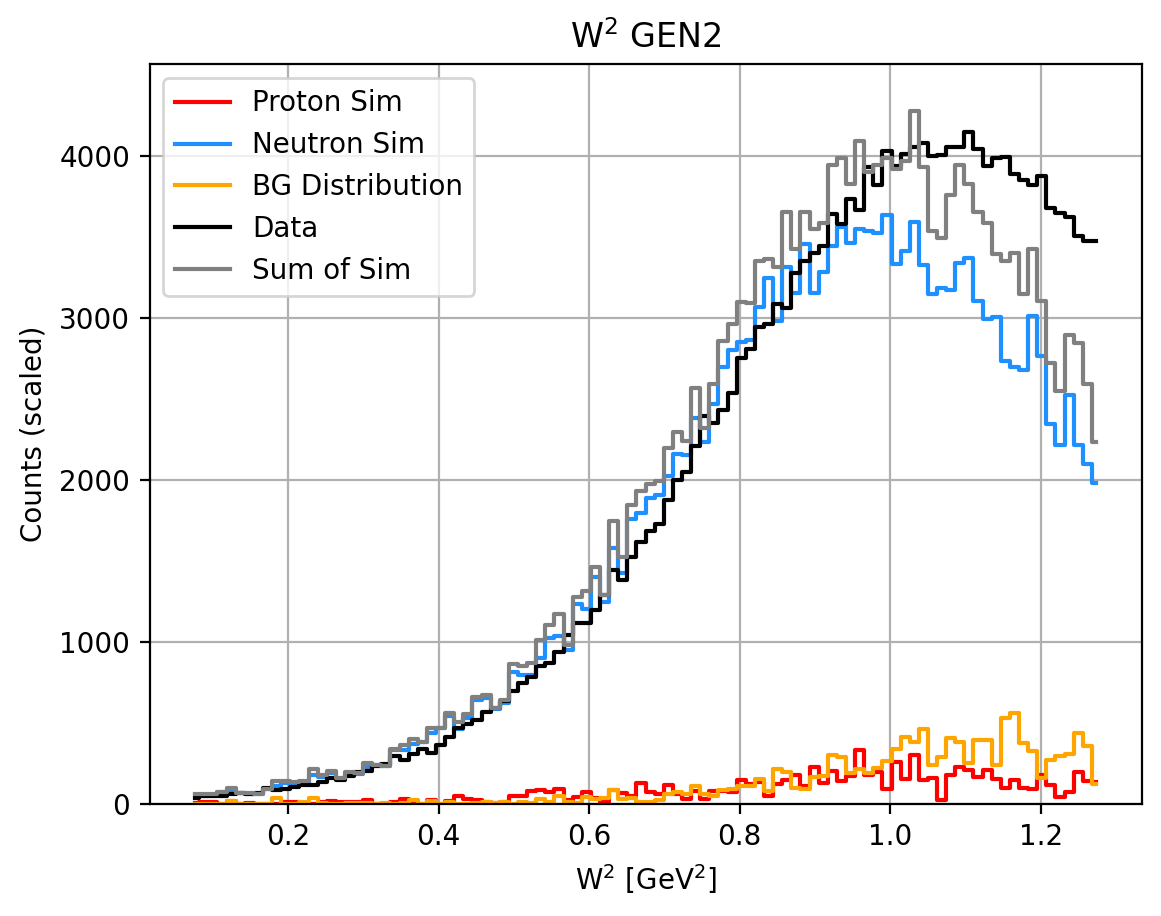

Total events in range (-0.95, 0.95):
  Sim Proton:   6280.36
  Sim Neutron:  134643.46
  Background:   9459.68
  Total:        150690.00
Fraction of events in range (-0.95, 0.95):
   Proton Fraction: 0.04
   Background Fraction: 0.06
   Neutron Fraction: 0.89
__________________________________________________
Target Weighted Avg: 0.356+-0.0179  5.0361%
Beam Weighted Avg: 0.841+-0.0018  0.2152%
__________________________________________________
epsilon = 0.7942
tau_avg = 0.8479
Q2 = 2.9939
Px: 0.9906 Pz: -0.0478
A = 0.15369 ± 0.00967 ± 0.00776
B = 0.61506 (no propagated error)
C = 0.13502 ± 0.01033 ± 0.00828
__________________________________________________
N_plus: 77550 N_minus: 71380
A_raw: 0.0414+=0.0026
A_raw_weighted: 0.0415+-0.0026  6.2399%
__________________________________________________
A_phys_weighted: 0.164
A_phys_stat_error: 0.0103  6.2942%
A_phys_sys_error: 0.0083  5.046%
GEn/GMn*muN_stat_error: -0.03635  8.1632%
GEn/GMn*muN_phys_sys_error: -0.02914  6.545%
GEn/GMn*muN: 0

In [132]:
#rel_contribs,_,statdict,Q2_avg=DoItAll(W2min,W2max,coinmin,coinmax,dymin,dymax,dxmin,dxmax)
rel_contribs,_,statdict,Q2_avg=DoItAll(new_W2min,new_W2max,new_coinmin,
                                       new_coinmax,new_dymin,new_dymax,new_dxmin,new_dxmax,hcalmin,
                                      psmin,epmin)




In [88]:
gen=[]
gensys=[]
genstat=[]
araw=[]
arawerror=[]
aphysstaterror=[]
aphyssyserror=[]
cutindex=[]
#w2scale
#coinscale
#dyscale
#dxscale


stepsize=20
print("Starting W2")
for i in range(0,stepsize):
    #print(i)
    try: _,_,stats1,_=DoItAll(.87-i/10,.88+i/20,coinmin,coinmax,dymin,dymax,dxmin,dxmax,hcalmin,False,False)
    except:
        continue
    cutindex.append(i)
    A=stats1['GE/GM * muN']
    B=stats1['GE/GM_stat_error']
    #print(A,B)
    C=stats1['GE/GM_sys_error']
    D=stats1['A_raw']
    E=stats1['A_raw_rel_error']
    F=stats1["A_phys_rel_sys_error"]
    G=stats1["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("Starting dx")
for i in range(0,20):
    #print(i)
    try: _,_,stats2,_=DoItAll(.87-8/10,.88+8/20,coinmin,coinmax,dymin,dymax,-.1-i/20,.1+i/20,hcalmin,False,False)
    except:
        continue
    cutindex.append(stepsize+i)
    A=stats2['GE/GM * muN']
    B=stats2['GE/GM_stat_error']
    C=stats2['GE/GM_sys_error']
    D=stats2['A_raw']
    E=stats2['A_raw_rel_error']
    F=stats2["A_phys_rel_sys_error"]
    G=stats2["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("Starting dy")
for i in range(0,20):
    #print(i)
    try: _,_,stats3,_=DoItAll(.87-8/10,.88+8/20,coinmin,coinmax,-.1-i/10,.1+i/10,-.1-17/20,.1+17/20,hcalmin,False,False)
    except:
        continue
    cutindex.append(2*stepsize+i)
    A=stats3['GE/GM * muN']
    B=stats3['GE/GM_stat_error']
    C=stats3['GE/GM_sys_error']
    D=stats3['A_raw']
    E=stats3['A_raw_rel_error']
    F=stats3["A_phys_rel_sys_error"]
    G=stats3["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("starting coin")
for i in range(0,20):
    #print(i)
    try: _,_,stats4,_=DoItAll(.87-8/10,.88+8/20,coinmin+6.5-i/2,coinmax-6.5+i/2,-.1-6/10,.1+6/10,-.1-17/20,.1+17/20,hcalmin,False,False)
    except:
        continue
    cutindex.append(3*stepsize+i)
    A=stats4['GE/GM * muN']
    B=stats4['GE/GM_stat_error']
    C=stats4['GE/GM_sys_error']
    D=stats4['A_raw']
    E=stats4['A_raw_rel_error']
    F=stats4["A_phys_rel_sys_error"]
    G=stats4["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)
print("starting hcale")
for i in range(0,20):
    #print(i)
    try: _,_,stats4,_=DoItAll(.87-8/10,.88+8/20,coinmin+6.5-7/2,coinmax-6.5+7/2,-.1-6/10,.1+6/10,-.1-17/20,.1+17/20,hcalmin+i/100,False,False)
    except:
        continue
    cutindex.append(4*stepsize+i)
    A=stats4['GE/GM * muN']
    B=stats4['GE/GM_stat_error']
    C=stats4['GE/GM_sys_error']
    D=stats4['A_raw']
    E=stats4['A_raw_rel_error']
    F=stats4["A_phys_rel_sys_error"]
    G=stats4["A_phys_rel_sat_error"]
    gen.append(A)
    gensys.append(C)
    genstat.append(B)
    araw.append(D)
    arawerror.append(E)
    aphysstaterror.append(G)
    aphyssyserror.append(F)

Starting W2
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Starting dx
Starting dy
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
starting coin


/home/research/GEn/GEn Data Analysis/analysis-pass2/../include/SIMFITS.py:83: RuntimeWarning: invalid value encountered in divide
  self.hdx_data[1] /= scale
/tmp/ipykernel_14284/1897007852.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  f_acc=outside_number/inside_number
/tmp/ipykernel_14284/1897007852.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  f_acc_error=f_acc * math.sqrt(1 / outside_number + 1 / inside_number)


Negative Fraction!


/tmp/ipykernel_14284/4075664822.py:129: RuntimeWarning: invalid value encountered in divide
  A_corrected_per_run = (A_raw_per_run - fA) / (1 - f)


Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
starting hcale
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!
Negative Fraction!


In [89]:
gen_error=np.sqrt(np.array(genstat)**2+np.array(gensys)**2)

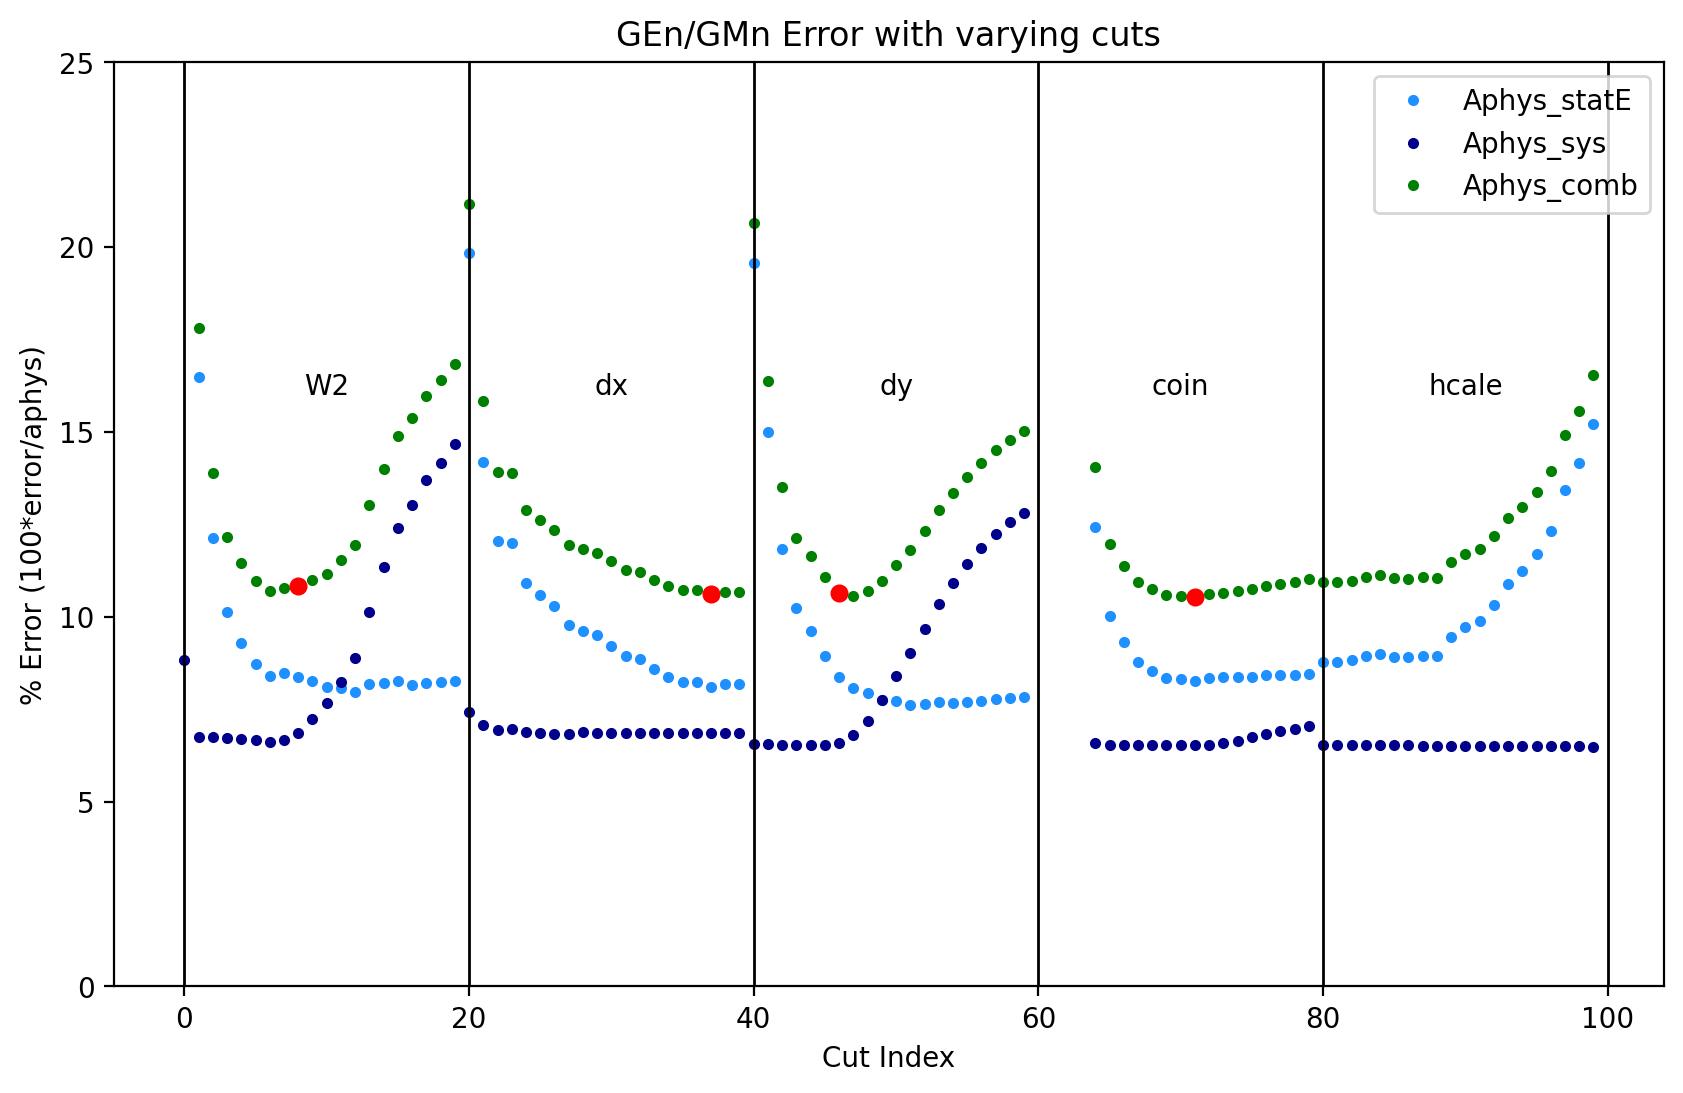

In [93]:
fig, ax1 = plt.subplots(figsize=(10,6), dpi=200)
msize = 11

# Plot aphys errors on the left y-axis
ax1.plot(cutindex, 100*np.array(genstat)/gen, '.', color='dodgerblue', label='Aphys_statE')
ax1.plot(cutindex, 100*np.array(gensys)/gen, '.', color='darkblue', label='Aphys_sys')
ax1.plot(cutindex, 100*(np.array(gensys)**2+np.array(genstat)**2)**(1/2)/gen, '.', color='green', label='Aphys_comb')

highlight_indices = [8, 17+stepsize, 6+2*stepsize, 7+3*stepsize]
for idx in highlight_indices:
    try:
        ax1.plot(cutindex[idx], 100*(np.array(gensys[idx])**2+np.array(genstat[idx])**2)**(1/2)/gen[idx], '.', color='red', markersize=msize)
       # ax1.plot(cutindex[idx], 100*np.array(gensys)[idx]/gen[idx], '.', color='red', markersize=msize)
    except: continue

ax1.set_ylabel("% Error (100*error/aphys)")
ax1.set_xlabel("Cut Index")
ax1.set_ylim(0, 25)
ax1.set_title("GEn/GMn Error with varying cuts")
ax1.axvline(0, color='black', linewidth=1)
ax1.axvline(stepsize, color='black', linewidth=1)
ax1.axvline(2*stepsize, color='black', linewidth=1)
ax1.axvline(3*stepsize, color='black', linewidth=1)
ax1.axvline(4*stepsize, color='black', linewidth=1)
ax1.axvline(5*stepsize, color='black', linewidth=1)

ax1.text(stepsize/2, 16, "W2", ha='center')
ax1.text(2*stepsize - stepsize/2, 16, "dx", ha='center')
ax1.text(3*stepsize - stepsize/2, 16, "dy", ha='center')
ax1.text(4*stepsize - stepsize/2, 16, "coin", ha='center')
ax1.text(5*stepsize - stepsize/2, 16, "hcale", ha='center')

# Create right y-axis
#ax2 = ax1.twinx()
#ax2.errorbar(cutindex, np.array(gen), gen_error, fmt='o', linestyle='none', color='black', label='GEn/GMn*muN',alpha=.1)
#ax2.set_ylabel("GEn/GMn*muN")  # Customize as needed
#ax2.set_ylim(0, 1)
#lines2, labels2 = ax2.get_legend_handles_labels()

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()

#ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax1.legend(lines1 , labels1 , loc='upper right')


(0.0, 0.4)

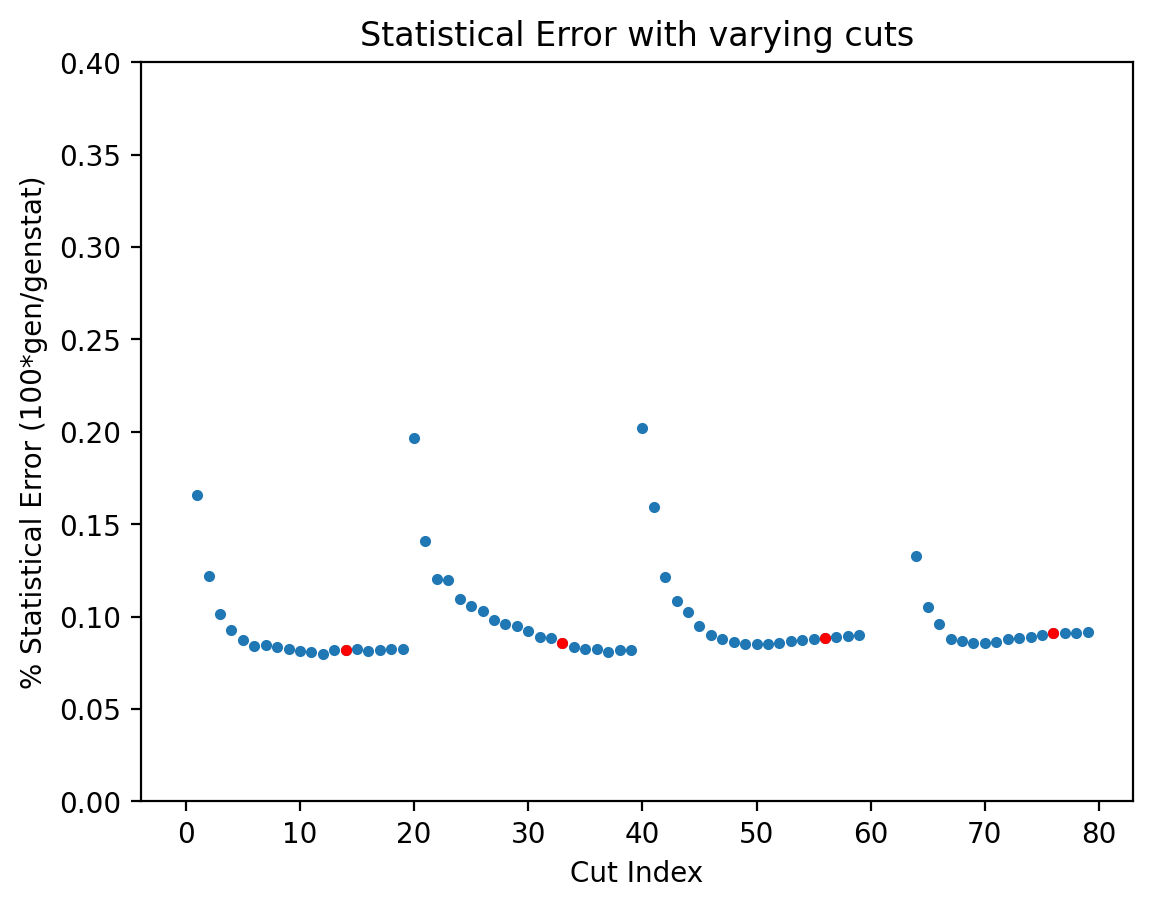

In [138]:
plt.figure(dpi=200)
plt.plot(cutindex,(np.array(genstat)/np.array(gen)),'.')
plt.plot(cutindex[14],(np.array(genstat)/np.array(gen))[14],'.',color='red')
plt.plot(cutindex[13+stepsize],(np.array(genstat)/np.array(gen))[13+stepsize],'.',color='red')
plt.plot(cutindex[16+2*stepsize],(np.array(genstat)/np.array(gen))[16+2*stepsize],'.',color='red')
plt.plot(cutindex[12+3*stepsize],(np.array(genstat)/np.array(gen))[12+3*stepsize],'.',color='red')
plt.ylabel("% Statistical Error (100*gen/genstat)")
plt.title("Statistical Error with varying cuts")
plt.xlabel("Cut Index")
plt.ylim(0,.4)

In [124]:
rel_contribs

{'f_acc': 0.005379626172952376,
 'f_p': 0.013081050256438458,
 'f_inelastic': 0.029951492789514485,
 'f_N2': 0.0037110020771573132,
 'A_acc': 0.15681622111919505,
 'A_p': 9.198929906391297e-05,
 'A_inelastic': 3.3342826995126003,
 'P': 96.45668591877309}

In [125]:
GEGM=statdict['GE/GM * muN']
GEGMstat=statdict['GE/GM_stat_error']
GEGMsys=statdict['GE/GM_sys_error']

In [126]:
GEGME=np.sqrt(GEGMstat**2+GEGMsys**2)

In [127]:
GEN2Data = {
    'Q2': [Q2_avg],
    'ExpName': ['GEn-II'],
    'R': [GEGM ],
    'R_err': [GEGME],
    'GEn': [0],   # assuming GEn and GEn_err are present in the file
    'GEn_err': [0]
}

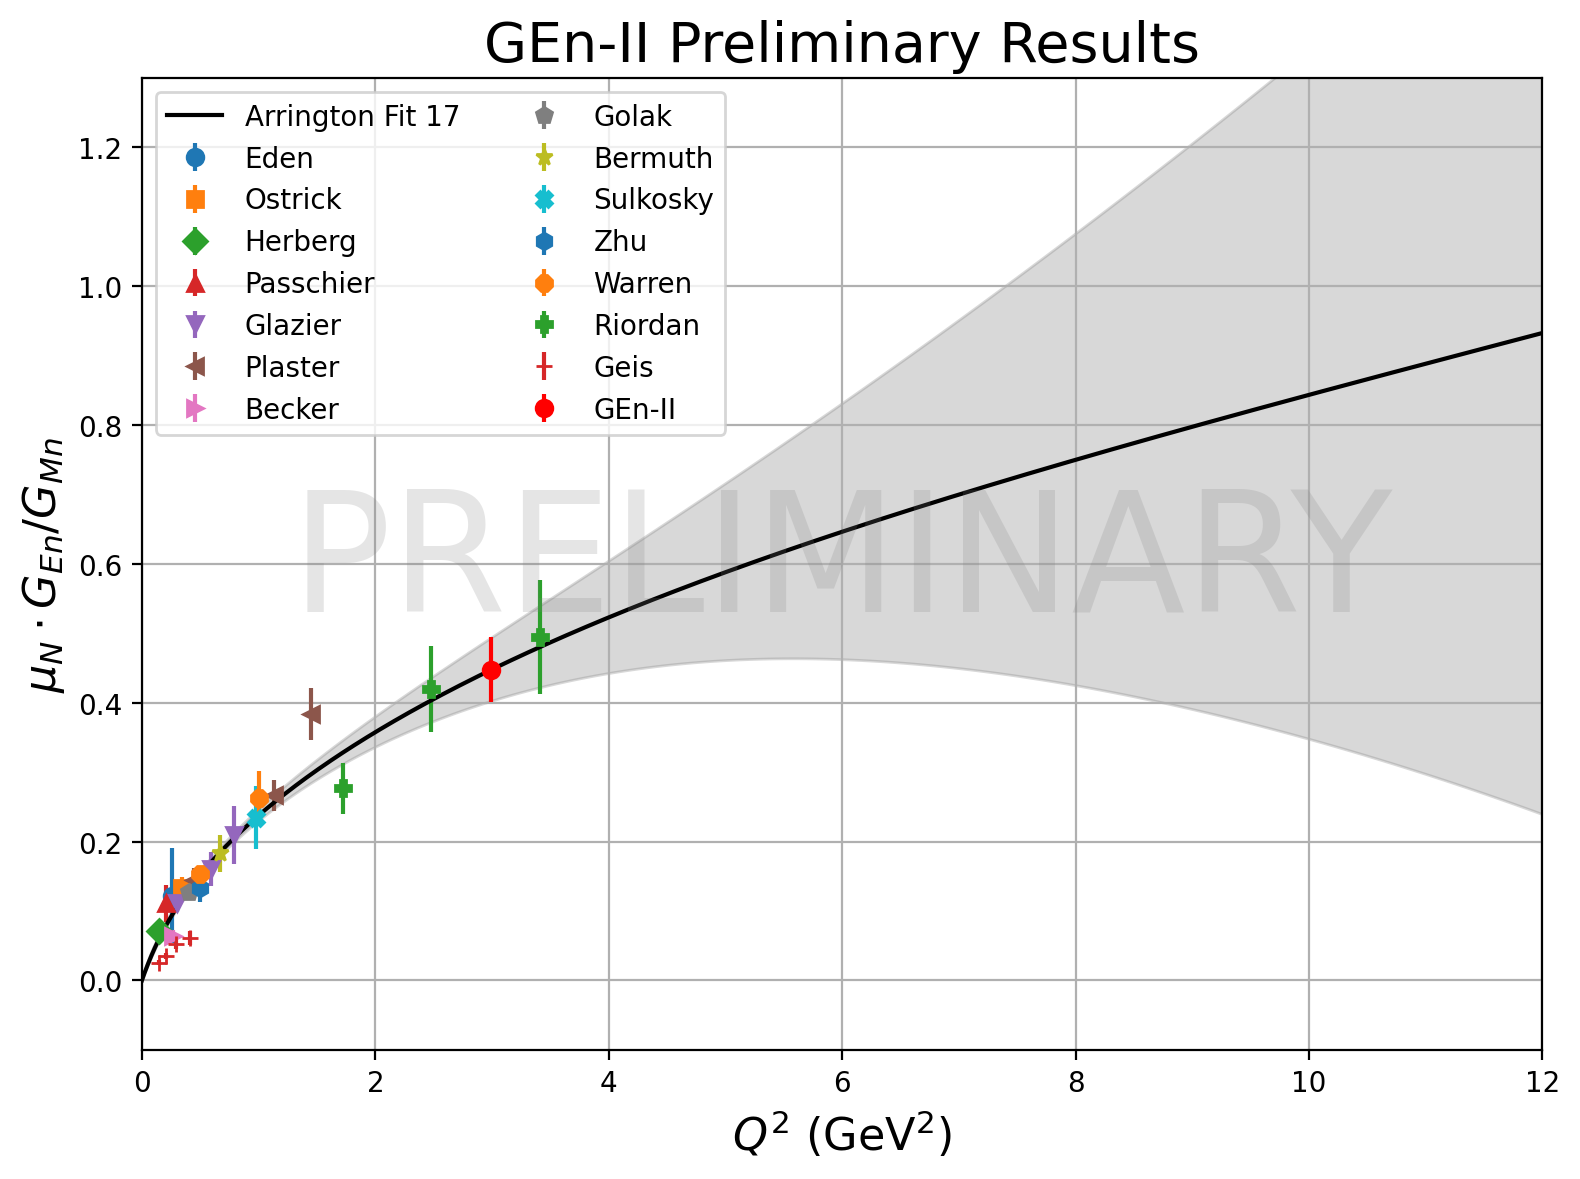

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GETFF import Function_GETFF  # Assuming you have this imported somewhere

# Load theory Q2 and GEn/GD ratio
GEntheory = np.transpose(np.loadtxt('../DB/neutron_lookup.dat'))
Q2t = np.sort(GEntheory[0])

# Calculate GE/GM and uncertainties using GETFF
GEGD, GEGDE, GMGD, GMGDE = [], [], [], []
for q2 in Q2t:
    GEGD.append(Function_GETFF(3, q2)[0])
    GEGDE.append(Function_GETFF(3, q2)[1])
    GMGD.append(Function_GETFF(4, q2)[0])
    GMGDE.append(Function_GETFF(4, q2)[1])

GEGD = np.array(GEGD)
GEGDE = np.array(GEGDE)
GMGD = np.array(GMGD)
GMGDE = np.array(GMGDE)

# Error propagation: GE/GM with uncertainty
def eprop(GE, GEE, GM, GMM):
    R = GE / GM
    fractional_error = np.sqrt((GEE / GE)**2 + (GMM / GM)**2)
    return R, R * fractional_error

RatFit, RatFitE = eprop(GEGD, GEGDE, GMGD, GMGDE)

# Load world data
df = pd.read_csv("../DB/GEn_World_Data.csv")
mu_n = 1.91

# Setup plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'h', '8', 'P', '+', 'x', '|', '_']
experiments = df["Experiment"].unique()
markers = {exp: marker_styles[i % len(marker_styles)] for i, exp in enumerate(experiments)}

# Plot world data
for exp in experiments:
    subset = df[df["Experiment"] == exp]
    ax.errorbar(subset["Q2"], mu_n * subset["GEn"] / subset["GMn"],
                subset["RatE"], fmt=markers[exp], label=exp)
plt.errorbar(GEN2Data['Q2'],GEN2Data['R'],GEN2Data['R_err'],fmt='o',color='red',label='GEn-II')

# Plot fit and shaded error band
ax.plot(Q2t, RatFit, color='black', label='Arrington Fit 17')
ax.fill_between(Q2t, RatFit - RatFitE, RatFit + RatFitE, color='gray', alpha=0.3)

# Watermark and labels
ax.text(0.5, 0.5, 'PRELIMINARY', fontsize=60, color='gray',
        ha='center', va='center', alpha=0.2, transform=ax.transAxes)

ax.set_xlim(0, 12)
ax.set_ylim(-0.1, 1.3)
ax.grid(True)
ax.set_xlabel('$Q^2$ (GeV$^2$)', fontsize=16)
ax.set_ylabel(r'$\mu_N \cdot G_{En} / G_{Mn}$', fontsize=16)
ax.set_title('GEn-II Preliminary Results', fontsize=20)
ax.legend(loc='upper left', fontsize=10, ncol=2)
#plt.yscale("log")
plt.tight_layout()
plt.savefig("PrelimResults.pdf")
plt.show()


In [117]:
with open("kin2results.txt",'w') as f:
    for i,key in enumerate(statdict):
        if i<4:
            f.write(key+","+f"{statdict[key]:.0f}\n")
        else:
            f.write(key+","+f"{statdict[key]:.4f}\n")